## Import Libraries and Modules

In [1]:
# Standard data analysis and plotting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300 # set the resolution of output plots to 600 dpi

# Standard machine learning libraries and modules
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Tensorflow 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Data Preprocessing and EDA

### NBA Players Performance and Salaries
Source: https://www.kaggle.com/datasets/thedevastator/exploring-nba-player-performance-and-salaries-19

#### Dataset guide

`Checked?` controls if a column has been converted to its correct data type

File: salaries_1985to2018.csv

| Column    | Description | Checked?
| -------- | ------- | -------
| league  | The league the player is in. (String) | Yes 
| salary  | The salary of the player. (Integer)    | Yes 
| season  | The season the player is playing in. (String)  | Yes 
| season_end | The end date of the season. (Date) | Yes 
| season_start | The start date of the season. (Date) | Yes  
| team         | The team the player is playing for. (String) | Yes 

File: players.csv

| Column     | Description | Checked?
| --------   | ------- | ------- 
| birthDate  | Date of birth of the player. (Date) | Yes
| birthPlace | Place of birth of the player. (String) | Yes
| career_AST | Career assists of the player. (Integer) | Yes
| career_FG% |Career field goal percentage of the player. (Float) | Yes
| career_FG3%|Career three-point field goal percentage of the player. (Float) | Yes
| career_FT% | Career free throw percentage of the player. (Float) | Yes
|career_G	 |Career games played by the player. (Integer) | Yes
|career_PER	 |Career player efficiency rating of the player. (Float) | Yes
|career_PTS	 |Career points scored by the player. (Integer)| Yes
|career_TRB	 |Career total rebounds of the player. (Integer)| ?
|career_WS	 |Career win shares of the player. (Float)| Yes
|career_eFG% |Career effective field goal percentage of the player. (Float)| ?
|college	 |College attended by the player. (String)| Yes
|draft_pick	 |Draft pick of the player. (Integer)| Yes
|draft_round |Round of the draft the player was selected in. (Integer)| Yes
|draft_team	 |Team that drafted the player. (String)| Yes
|draft_year	 |Year the player was drafted. (Integer)| Yes
|height	     |Height of the player. (Float) | Yes
|highSchool	 |High school attended by the player. (String) | Yes
|name	     |Name of the player. (String) | Yes
|position	 |Position of the player. (String) | Yes
|shoots	     |Shooting hand preference of the player. (String) | Yes
|weight	     |Weight of the player. (Integer) | Yes



### Read and Merge

In [2]:
salaries = pd.read_csv("Dataset/salaries_1985to2018.csv")
players = pd.read_csv("Dataset/players.csv")

In [3]:
salaries.shape

(14163, 8)

In [4]:
players.shape

(4685, 25)

The next steps is to merge the two datasets to get a unified one. <br>
Let's explore the columns and find a unique column name that we can merge on:

In [5]:
salaries.columns

Index(['index', 'league', 'player_id', 'salary', 'season', 'season_end',
       'season_start', 'team'],
      dtype='object')

In [6]:
players.columns

Index(['index', '_id', 'birthDate', 'birthPlace', 'career_AST', 'career_FG%',
       'career_FG3%', 'career_FT%', 'career_G', 'career_PER', 'career_PTS',
       'career_TRB', 'career_WS', 'career_eFG%', 'college', 'draft_pick',
       'draft_round', 'draft_team', 'draft_year', 'height', 'highSchool',
       'name', 'position', 'shoots', 'weight'],
      dtype='object')

Both datasets `salaries` and `players` have their own index. Yet, we don't need more than one index for the merged dataset. So we drop the `index` column from one of the DataFrames (e.g., from `salaries`):

In [7]:
salaries.drop(columns=['index'], inplace=True)

We observe that, `player_id` in `salaries` and `_id` in `players` are common. Thus, we merge on id values using inner join to keep those players for whom salary details are availale. We also keep in mind to add `left_on` and `right_on` as the key columns have different names. Name the merged DataFrame `nba_salary_stats`:

In [8]:
nba_salary_stats = salaries.merge(players, how='inner', left_on='player_id', right_on='_id')
nba_salary_stats.head()

league  player_id  salary   season  season_end  season_start  \
0    NBA  abdelal01  395000  1990-91        1991          1990   
1    NBA  abdelal01  494000  1991-92        1992          1991   
2    NBA  abdelal01  500000  1992-93        1993          1992   
3    NBA  abdelal01  805000  1993-94        1994          1993   
4    NBA  abdelal01  650000  1994-95        1995          1994   

                     team  index        _id      birthDate  ...    draft_pick  \
0  Portland Trail Blazers      0  abdelal01  June 24, 1968  ...  25th overall   
1  Portland Trail Blazers      0  abdelal01  June 24, 1968  ...  25th overall   
2          Boston Celtics      0  abdelal01  June 24, 1968  ...  25th overall   
3          Boston Celtics      0  abdelal01  June 24, 1968  ...  25th overall   
4        Sacramento Kings      0  abdelal01  June 24, 1968  ...  25th overall   

   draft_round              draft_team draft_year height  \
0    1st round  Portland Trail Blazers       1990   6-10   
1    1st round  Portland Trail Blazers       1990   6-10   
2    1st round  Portland Trail Blazers       1990   6-10   
3    1st round  Portland Trail Blazers       1990   6-10   
4    1st round  Portland Trail Blazers       1990   6-10   

                             highSchool            name       position shoots  \
0  Bloomfield in Bloomfield, New Jersey  Alaa Abdelnaby  Power Forward  Right   
1  Bloomfield in Bloomfield, New Jersey  Alaa Abdelnaby  Power Forward  Right   
2  Bloomfield in Bloomfield, New Jersey  Alaa Abdelnaby  Power Forward  Right   
3  Bloomfield in Bloomfield, New Jersey  Alaa Abdelnaby  Power Forward  Right   
4  Bloomfield in Bloomfield, New Jersey  Alaa Abdelnaby  Power Forward  Right   

  weight  
0  240lb  
1  240lb  
2  240lb  
3  240lb  
4  240lb  

[5 rows x 32 columns]

Delete one of the redundant id columns, for instance `_id` from `nba_salary_stats`:

In [9]:
nba_salary_stats.drop(columns=['_id'], inplace=True)

Checking again:

In [10]:
nba_salary_stats.columns

Index(['league', 'player_id', 'salary', 'season', 'season_end', 'season_start',
       'team', 'index', 'birthDate', 'birthPlace', 'career_AST', 'career_FG%',
       'career_FG3%', 'career_FT%', 'career_G', 'career_PER', 'career_PTS',
       'career_TRB', 'career_WS', 'career_eFG%', 'college', 'draft_pick',
       'draft_round', 'draft_team', 'draft_year', 'height', 'highSchool',
       'name', 'position', 'shoots', 'weight'],
      dtype='object')

From now on, we work with `nba_salary_stats`.

Number of rows and columns in order:

In [11]:
nba_salary_stats.shape

(14163, 31)

Check for NaN values 

In [12]:
nba_salary_stats.isna().sum()

league             0
player_id          0
salary             0
season             0
season_end         0
season_start       0
team               4
index              0
birthDate          0
birthPlace         0
career_AST         0
career_FG%         0
career_FG3%        0
career_FT%         0
career_G           0
career_PER         0
career_PTS         0
career_TRB         0
career_WS          0
career_eFG%        0
college         1636
draft_pick      1902
draft_round     1902
draft_team      1902
draft_year      1902
height             0
highSchool       989
name               0
position           0
shoots             0
weight             0
dtype: int64

In [13]:
nba_salary_stats.shape

(14163, 31)

In [14]:
nba_salary_stats["career_FG3%"].isna().sum()

0

Check number of rows after removing NaNs:

In [15]:
nba_salary_stats.shape

(14163, 31)

Note that 3370 rows with NaNs are removed

Check for duplicated rows:

In [16]:
duplicated_rows = nba_salary_stats.duplicated().sum()
duplicated_rows

0

The data type of columns:

In [17]:
nba_salary_stats.dtypes

league           object
player_id        object
salary            int64
season           object
season_end        int64
season_start      int64
team             object
index             int64
birthDate        object
birthPlace       object
career_AST      float64
career_FG%       object
career_FG3%      object
career_FT%       object
career_G          int64
career_PER       object
career_PTS      float64
career_TRB       object
career_WS        object
career_eFG%      object
college          object
draft_pick       object
draft_round      object
draft_team       object
draft_year       object
height           object
highSchool       object
name             object
position         object
shoots           object
weight           object
dtype: object

### Column transformation and EDA

We notice several columns of object type which need to be converted to numeric ones. I tried the standard type casting method `.astype()` but it didn't work out, since these columns contain special characters. Instead, I use custom lambda functions to strip off the special characters and only keep the numeric part. The columns `weight` and `height` are a bit more complicated because they contain special characters, and top of that, each needs to be converted to SI units (kg, cm).

Convert `weight`, `height` and all columns that contain special characters:

In [18]:
# Convert 'weight' from lb format to kg 
nba_salary_stats['weight'] = nba_salary_stats['weight'].apply(
    lambda x: float(str(x).replace('lb', '')) * 0.453592 
)

# Convert 'height' from feet-inches format to cm
nba_salary_stats["height"] = nba_salary_stats["height"].apply(
    lambda x: float(x.split("-")[0]) * 30.48 + float(x.split("-")[1]) * 2.54 if 
    isinstance(x, str) and "-" in x else np.nan  # Handle NaN or unexpected formats
)

# Custom function to remove special characters from other columns and set them into numeric
extract_numeric = lambda series: series.astype(str).str.extract(r'([-+]?\d*\.?\d+)', expand=False).astype(float)

cols_to_convert = ["career_FG%", "career_FG3%", "career_eFG%", "career_FT%", 
                   "career_PER", "draft_year", "career_WS", "draft_pick"]

nba_salary_stats[cols_to_convert] = nba_salary_stats[cols_to_convert].apply(extract_numeric)

Convert `birthDate` to datetime object:

In [19]:
# Convert `birthDate` to datetime object:
nba_salary_stats['birthDate'] = pd.to_datetime(
    nba_salary_stats['birthDate'], 
    format='%B %d, %Y'  # matching "MonthName Day, Year" format
)

Split `birthPlace` into `birth_city` and `nationality` columns:

In [20]:
# Split 'birthPlace' into 'birth_city' and 'nationality'
nba_salary_stats[['birth_city', 'nationality']] = nba_salary_stats['birthPlace'].str.split(', ', expand=True)
# Display a few rows to confirm changes
nba_salary_stats[["birthPlace", "birth_city", "nationality"]].head()

birthPlace birth_city nationality
0  Cairo, Egypt      Cairo       Egypt
1  Cairo, Egypt      Cairo       Egypt
2  Cairo, Egypt      Cairo       Egypt
3  Cairo, Egypt      Cairo       Egypt
4  Cairo, Egypt      Cairo       Egypt

Add a `draft_age` column which is the age that a player is drafted:

In [21]:
# Ensure birthDate is a datetime object
nba_salary_stats["birthDate"] = pd.to_datetime(nba_salary_stats["birthDate"], errors="coerce")

# Convert draft_year to integer
nba_salary_stats["draft_year"] = nba_salary_stats["draft_year"].fillna(0).astype(int)

# Compute draft age
nba_salary_stats["draft_age"] = nba_salary_stats["draft_year"] - nba_salary_stats["birthDate"].dt.year

# Replace negative values in the draft_age column with the median of positive values
# Calculate median of positive draft ages
positive_median = nba_salary_stats.loc[nba_salary_stats["draft_age"] > 0, "draft_age"].median()

# Replace negative values with the median of positive ages
nba_salary_stats["draft_age"] = nba_salary_stats["draft_age"].apply(
    lambda x: positive_median if x < 0 else x
)

# Display a few rows to confirm changes
nba_salary_stats[["birthDate", "draft_year", "draft_age"]].head()

birthDate  draft_year  draft_age
0 1968-06-24        1990       22.0
1 1968-06-24        1990       22.0
2 1968-06-24        1990       22.0
3 1968-06-24        1990       22.0
4 1968-06-24        1990       22.0

Remove nan values:

In [22]:
nba_salary_stats.dropna(inplace=True)
nba_salary_stats.isna().sum()

league          0
player_id       0
salary          0
season          0
season_end      0
season_start    0
team            0
index           0
birthDate       0
birthPlace      0
career_AST      0
career_FG%      0
career_FG3%     0
career_FT%      0
career_G        0
career_PER      0
career_PTS      0
career_TRB      0
career_WS       0
career_eFG%     0
college         0
draft_pick      0
draft_round     0
draft_team      0
draft_year      0
height          0
highSchool      0
name            0
position        0
shoots          0
weight          0
birth_city      0
nationality     0
draft_age       0
dtype: int64

In [23]:
nba_salary_stats.columns

Index(['league', 'player_id', 'salary', 'season', 'season_end', 'season_start',
       'team', 'index', 'birthDate', 'birthPlace', 'career_AST', 'career_FG%',
       'career_FG3%', 'career_FT%', 'career_G', 'career_PER', 'career_PTS',
       'career_TRB', 'career_WS', 'career_eFG%', 'college', 'draft_pick',
       'draft_round', 'draft_team', 'draft_year', 'height', 'highSchool',
       'name', 'position', 'shoots', 'weight', 'birth_city', 'nationality',
       'draft_age'],
      dtype='object')

DataFrame info:

In [24]:
nba_salary_stats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10519 entries, 0 to 14156
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   league        10519 non-null  object        
 1   player_id     10519 non-null  object        
 2   salary        10519 non-null  int64         
 3   season        10519 non-null  object        
 4   season_end    10519 non-null  int64         
 5   season_start  10519 non-null  int64         
 6   team          10519 non-null  object        
 7   index         10519 non-null  int64         
 8   birthDate     10519 non-null  datetime64[ns]
 9   birthPlace    10519 non-null  object        
 10  career_AST    10519 non-null  float64       
 11  career_FG%    10519 non-null  float64       
 12  career_FG3%   10519 non-null  float64       
 13  career_FT%    10519 non-null  float64       
 14  career_G      10519 non-null  int64         
 15  career_PER    10519 non-null  float64    

Summary statistics of numerical values:

In [25]:
nba_salary_stats.describe()

salary    season_end  season_start         index  \
count  1.051900e+04  10519.000000  10519.000000  10519.000000   
mean   3.220446e+06   2002.374370   2001.374370   2305.575530   
min    2.706000e+03   1985.000000   1984.000000      0.000000   
25%    7.023780e+05   1995.000000   1994.000000   1117.000000   
50%    1.596360e+06   2002.000000   2001.000000   2285.000000   
75%    3.983000e+06   2010.000000   2009.000000   3474.000000   
max    3.468255e+07   2018.000000   2017.000000   4676.000000   
std    4.129348e+06      9.342095      9.342095   1365.163975   

                           birthDate    career_AST    career_FG%  \
count                          10519  10519.000000  10519.000000   
mean   1974-08-13 18:43:13.478467520      2.203042     45.473125   
min              1947-04-16 00:00:00      0.000000      0.000000   
25%              1966-03-12 00:00:00      0.900000     42.500000   
50%              1974-01-31 00:00:00      1.700000     45.300000   
75%              1983-02-01 00:00:00      2.900000     48.400000   
max              1998-05-29 00:00:00     11.200000     67.000000   
std                              NaN      1.795460      4.552971   

        career_FG3%    career_FT%      career_G    career_PER    career_PTS  \
count  10519.000000  10519.000000  10519.000000  10519.000000  10519.000000   
mean      26.277745     74.131495    648.744843     14.072573      9.818547   
min        0.000000      0.000000      1.000000    -18.400000      0.000000   
25%       19.250000     69.600000    408.000000     11.900000      5.900000   
50%       31.100000     75.400000    657.000000     13.800000      9.000000   
75%       35.400000     80.300000    880.000000     16.000000     13.100000   
max      100.000000    100.000000   1611.000000     27.900000     30.100000   
std       12.482247      8.804168    334.594588      3.565080      5.067328   

          career_WS   career_eFG%    draft_pick    draft_year        height  \
count  10519.000000  10519.000000  10519.000000  10519.000000  10519.000000   
mean      38.935222     48.413110     22.243654   1995.966252    200.460306   
min       -2.700000      0.000000      1.000000   1969.000000    160.020000   
25%       11.050000     46.400000      8.000000   1988.000000    193.040000   
50%       28.300000     48.600000     18.000000   1996.000000    200.660000   
75%       55.400000     50.600000     32.000000   2004.000000    207.010000   
max      273.400000     67.000000    221.000000   2017.000000    231.140000   
std       38.236324      4.011821     19.795231     10.028667      9.114326   

             weight     draft_age  
count  10519.000000  10519.000000  
mean      98.209546     21.837817  
min       60.327736     19.000000  
25%       88.450440     21.000000  
50%       98.883056     22.000000  
75%      106.594120     23.000000  
max      147.417400     27.000000  
std       12.107477      1.160340

Random sample of 10 rows:

In [26]:
nba_salary_stats.sample(10)

league  player_id    salary   season  season_end  season_start  \
3110     NBA  davisri01   4546000  2002-03        2003          2002   
2555     NBA  collida01   4797664  2014-15        2015          2014   
12884    NBA  vaughlo01   3830000  1998-99        1999          1998   
13683    NBA  willije01    652800  1997-98        1998          1997   
596      NBA  augmost01   2400000  2001-02        2002          2001   
5703     NBA  hinriki01  10000000  2008-09        2009          2008   
11890    NBA  sprewla01  13500000  2003-04        2004          2003   
8632     NBA  milleda01    788872  2013-14        2014          2013   
2340     NBA  chapmre01   2004500  1994-95        1995          1994   
6502     NBA  johnsbr02   1331160  2017-18        2018          2017   

                         team  index  birthDate  \
3110      Cleveland Cavaliers    965 1979-09-23   
2555         Sacramento Kings    783 1987-08-23   
12884         Detroit Pistons   4263 1968-02-27   
13683         Detroit Pistons   4515 1973-05-10   
596         Charlotte Hornets    151 1968-08-01   
5703            Chicago Bulls   1838 1981-01-02   
11890  Minnesota Timberwolves   3936 1970-09-08   
8632     New Orleans Pelicans   2841 1990-03-21   
2340       Washington Bullets    707 1967-10-05   
6502        Memphis Grizzlies   2064 1994-06-27   

                             birthPlace  ...  draft_year  height  \
3110                  Las Vegas, Nevada  ...        1998  198.12   
2555       Rancho Cucamonga, California  ...        2009  182.88   
12884            Grand Rapids, Michigan  ...        1990  205.74   
13683  Washington, District of Columbia  ...        1996  205.74   
596                Pasadena, California  ...        1991  203.20   
5703                   Sioux City, Iowa  ...        2003  193.04   
11890              Milwaukee, Wisconsin  ...        1992  195.58   
8632                Maysville, Kentucky  ...        2012  203.20   
2340            Bowling Green, Kentucky  ...        1988  193.04   
6502         Orangeburg, South Carolina  ...        2016  208.28   

                                     highSchool              name  \
3110                   North in Davenport, Iowa       Ricky Davis   
2555   Etiwanda in Rancho Cucamonga, California   Darren Collison   
12884       East Kentwood in Kentwood, Michigan        Loy Vaught   
13683           Magruder in Rockville, Maryland   Jerome Williams   
596           John Muir in Pasadena, California     Stacey Augmon   
5703        Sioux City West in Sioux City, Iowa      Kirk Hinrich   
11890        Washington in Milwaukee, Wisconsin  Latrell Sprewell   
8632        Mason County in Maysville, Kentucky     Darius Miller   
2340              Apollo in Owensboro, Kentucky       Rex Chapman   
6502          Edisto in Cordova, South Carolina     Brice Johnson   

                               position  shoots      weight        birth_city  \
3110   Small Forward and Shooting Guard   Right   88.450440         Las Vegas   
2555                        Point Guard   Right   79.378600  Rancho Cucamonga   
12884                     Power Forward   Right  104.326160      Grand Rapids   
13683   Power Forward and Small Forward   Right   93.439952        Washington   
596    Small Forward and Shooting Guard    Left   92.986360          Pasadena   
5703     Point Guard and Shooting Guard   Right   86.182480        Sioux City   
11890  Small Forward and Shooting Guard   Right   86.182480         Milwaukee   
8632                      Small Forward   Right  102.058200         Maysville   
2340     Shooting Guard and Point Guard   Right   83.914520     Bowling Green   
6502                      Power Forward   Right  104.326160        Orangeburg   

                nationality  draft_age  
3110                 Nevada       19.0  
2555             California       22.0  
12884              Michigan       22.0  
13683  District of Columbia       23.0  
596              California       23.0  
5703

Number of unique players:

In [27]:
nba_salary_stats['player_id'].nunique()

1554

Number of players by state:

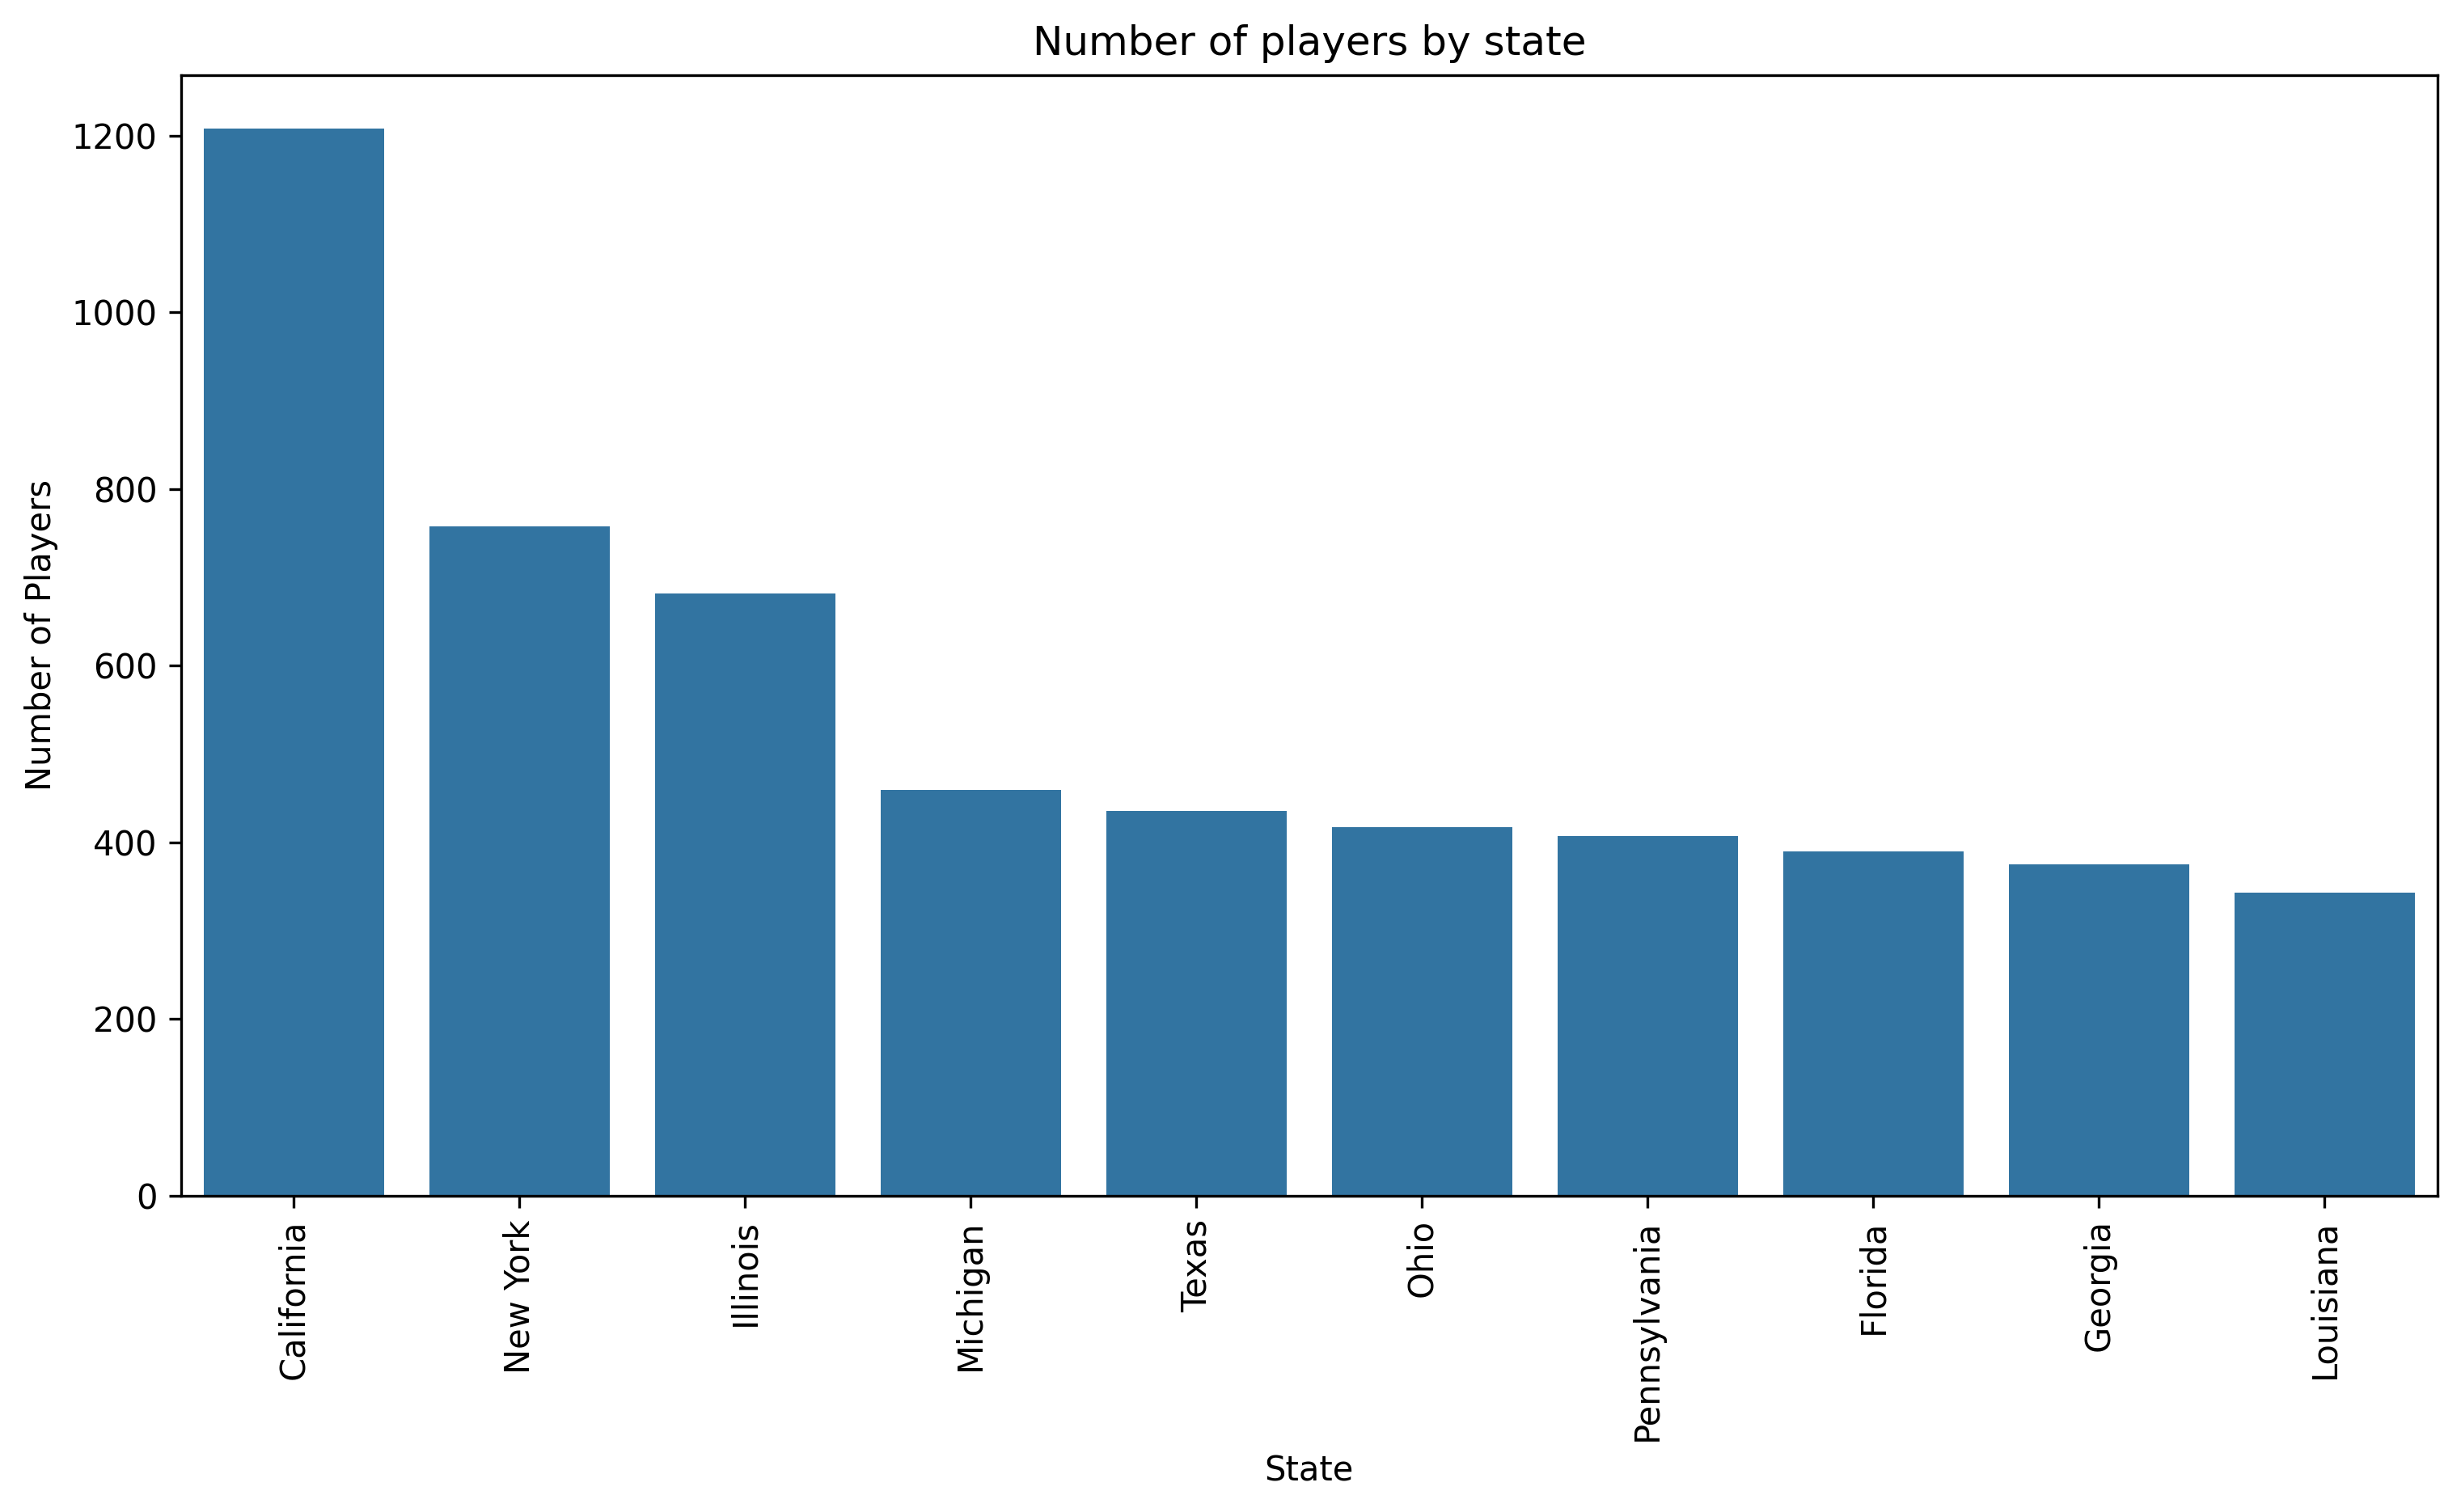

In [28]:
# Count the number of players per state/country of birth and select the top 10
top_nationalities = nba_salary_stats['nationality'].value_counts().nlargest(10)

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=top_nationalities.index, y=top_nationalities.values)

# Customize the plot
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.xlabel('State')
plt.ylabel('Number of Players')
plt.title('Number of players by state')

# Show the plot
plt.show()

Salary Distribution:

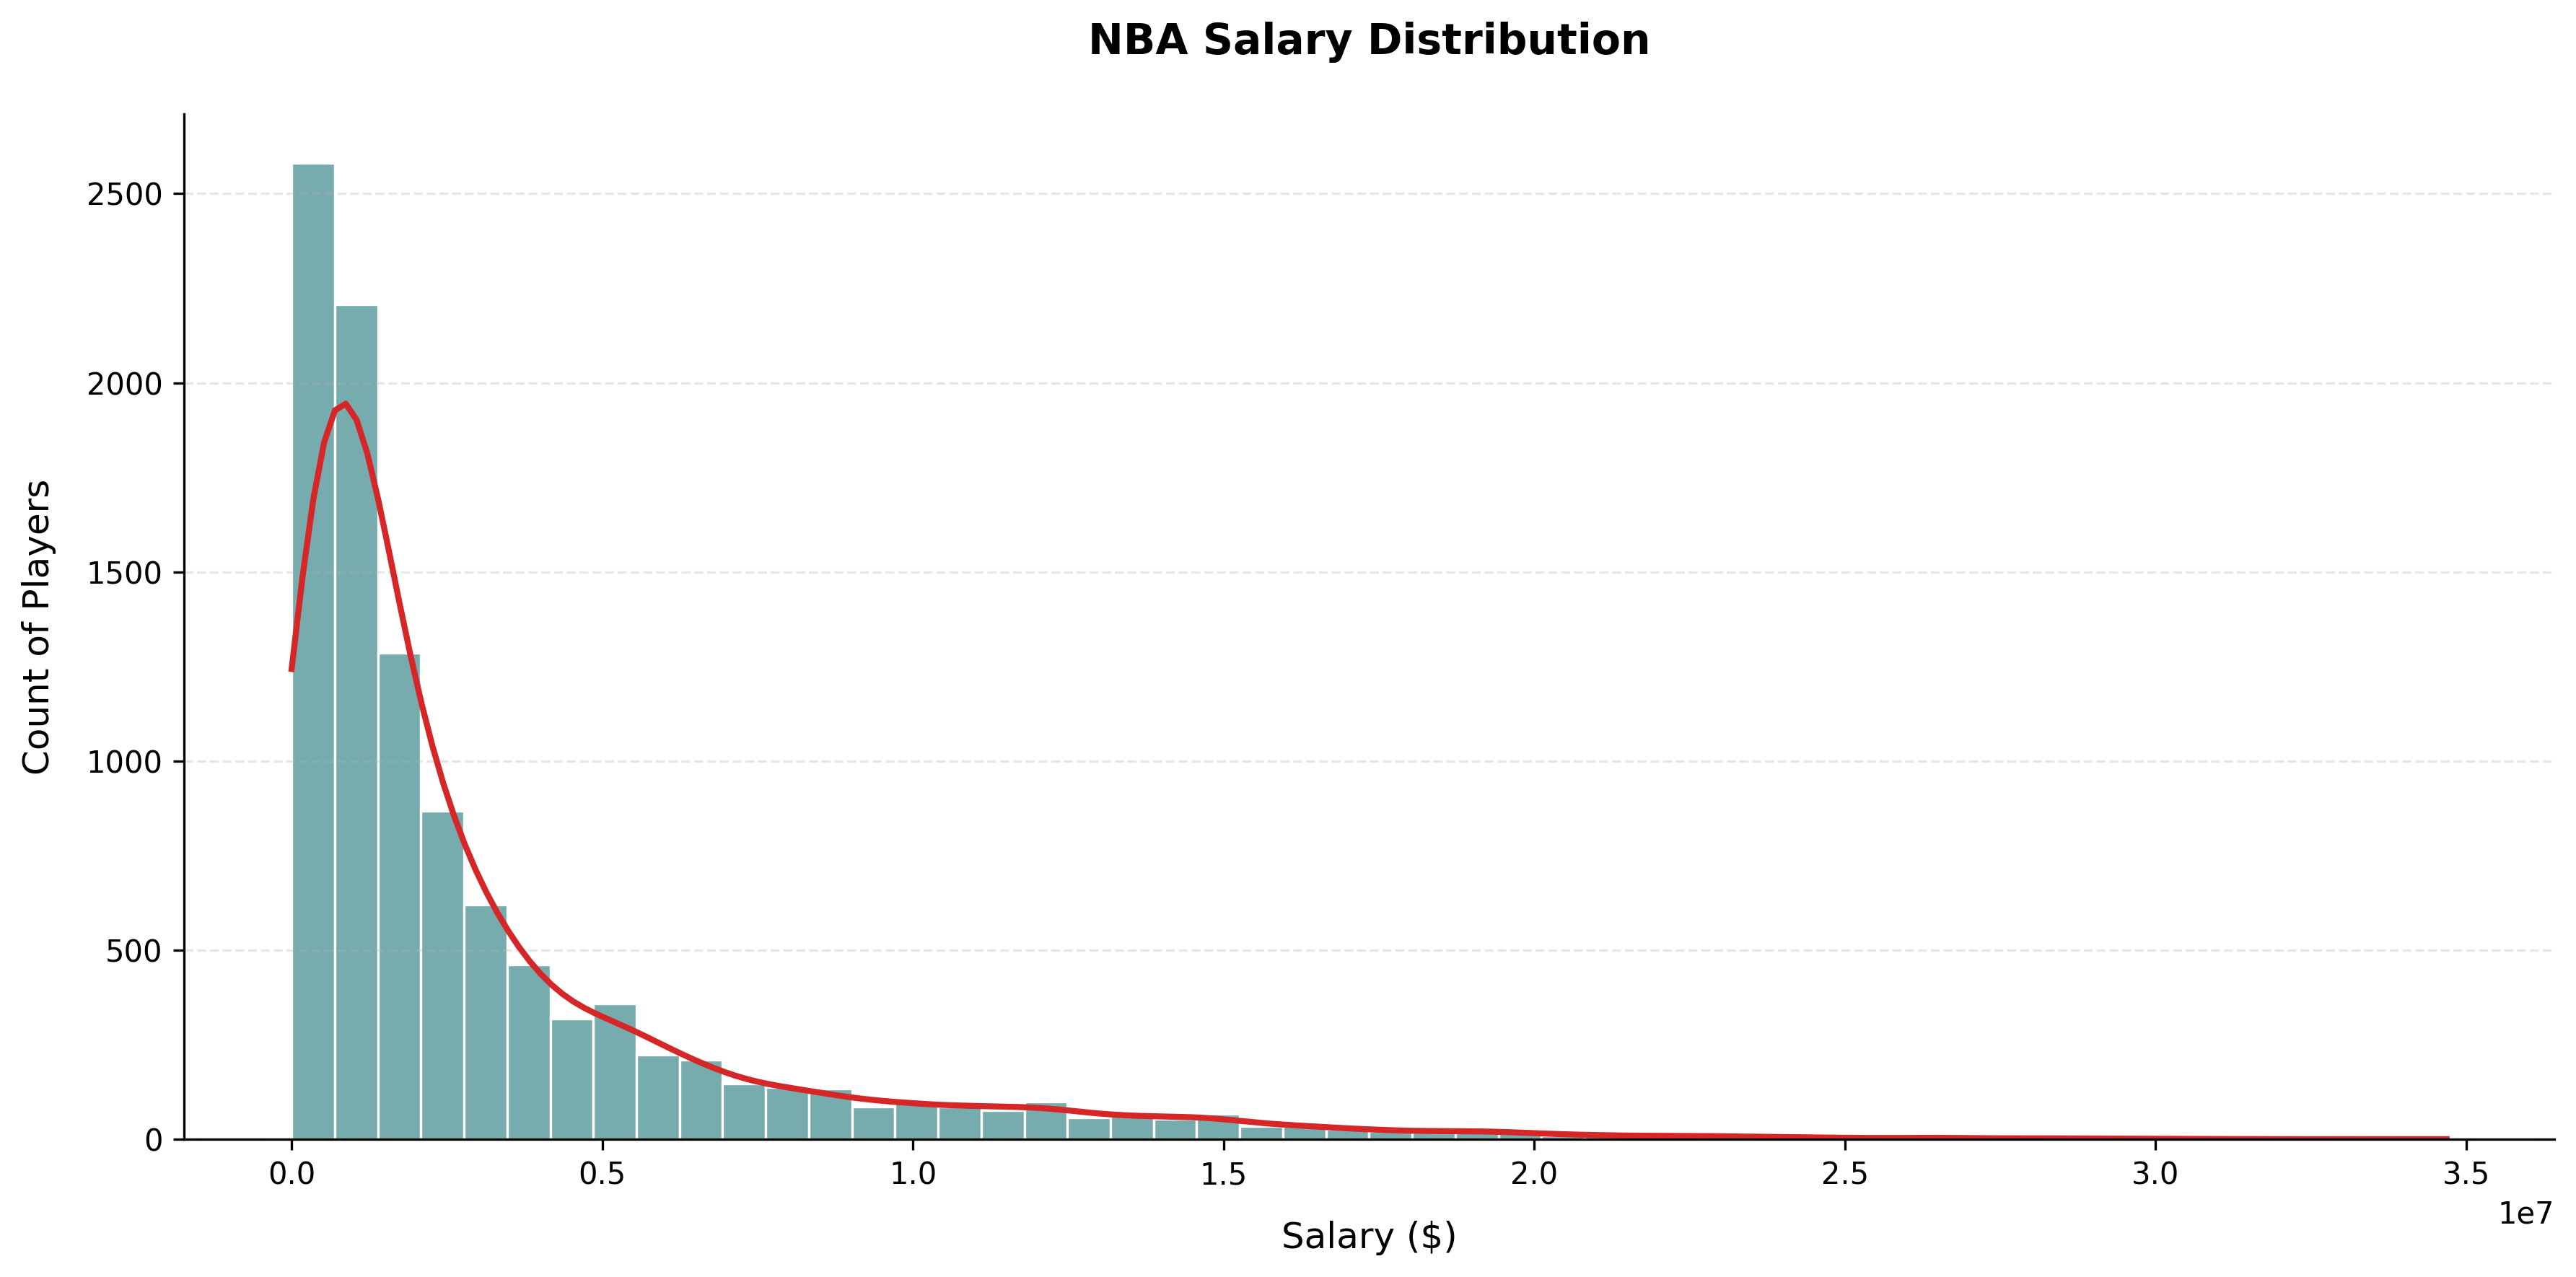

In [29]:
# Set up figure with improved proportions
plt.figure(figsize=(12, 6), facecolor='white')  # Wider aspect ratio

# Create histogram with refined styling
ax = sns.histplot(
    nba_salary_stats['salary'],
    bins=50,
    kde=True,
    color='#5F9EA0',  # More sophisticated blue
    edgecolor='white',  # Clean bar edges
    linewidth=0.8,  # Subtle border
    alpha=0.85  # Slight transparency
)

# KDE line styling
for line in ax.lines:  # Access the KDE line
    line.set_color('#d62728')  # Contrasting red
    line.set_linewidth(2)  # Thicker line

# Customize labels with improved typography
plt.xlabel('Salary ($)', fontsize=12, labelpad=10, fontweight='normal')
plt.ylabel('Count of Players', fontsize=12, labelpad=10, fontweight='normal')
plt.title('NBA Salary Distribution', 
          fontsize=14, pad=20, fontweight='bold')

# Improve tick marks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add light grid for better readability
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Remove top and right spines for cleaner look
sns.despine()

plt.tight_layout()
plt.show()

Draft pick distribution:

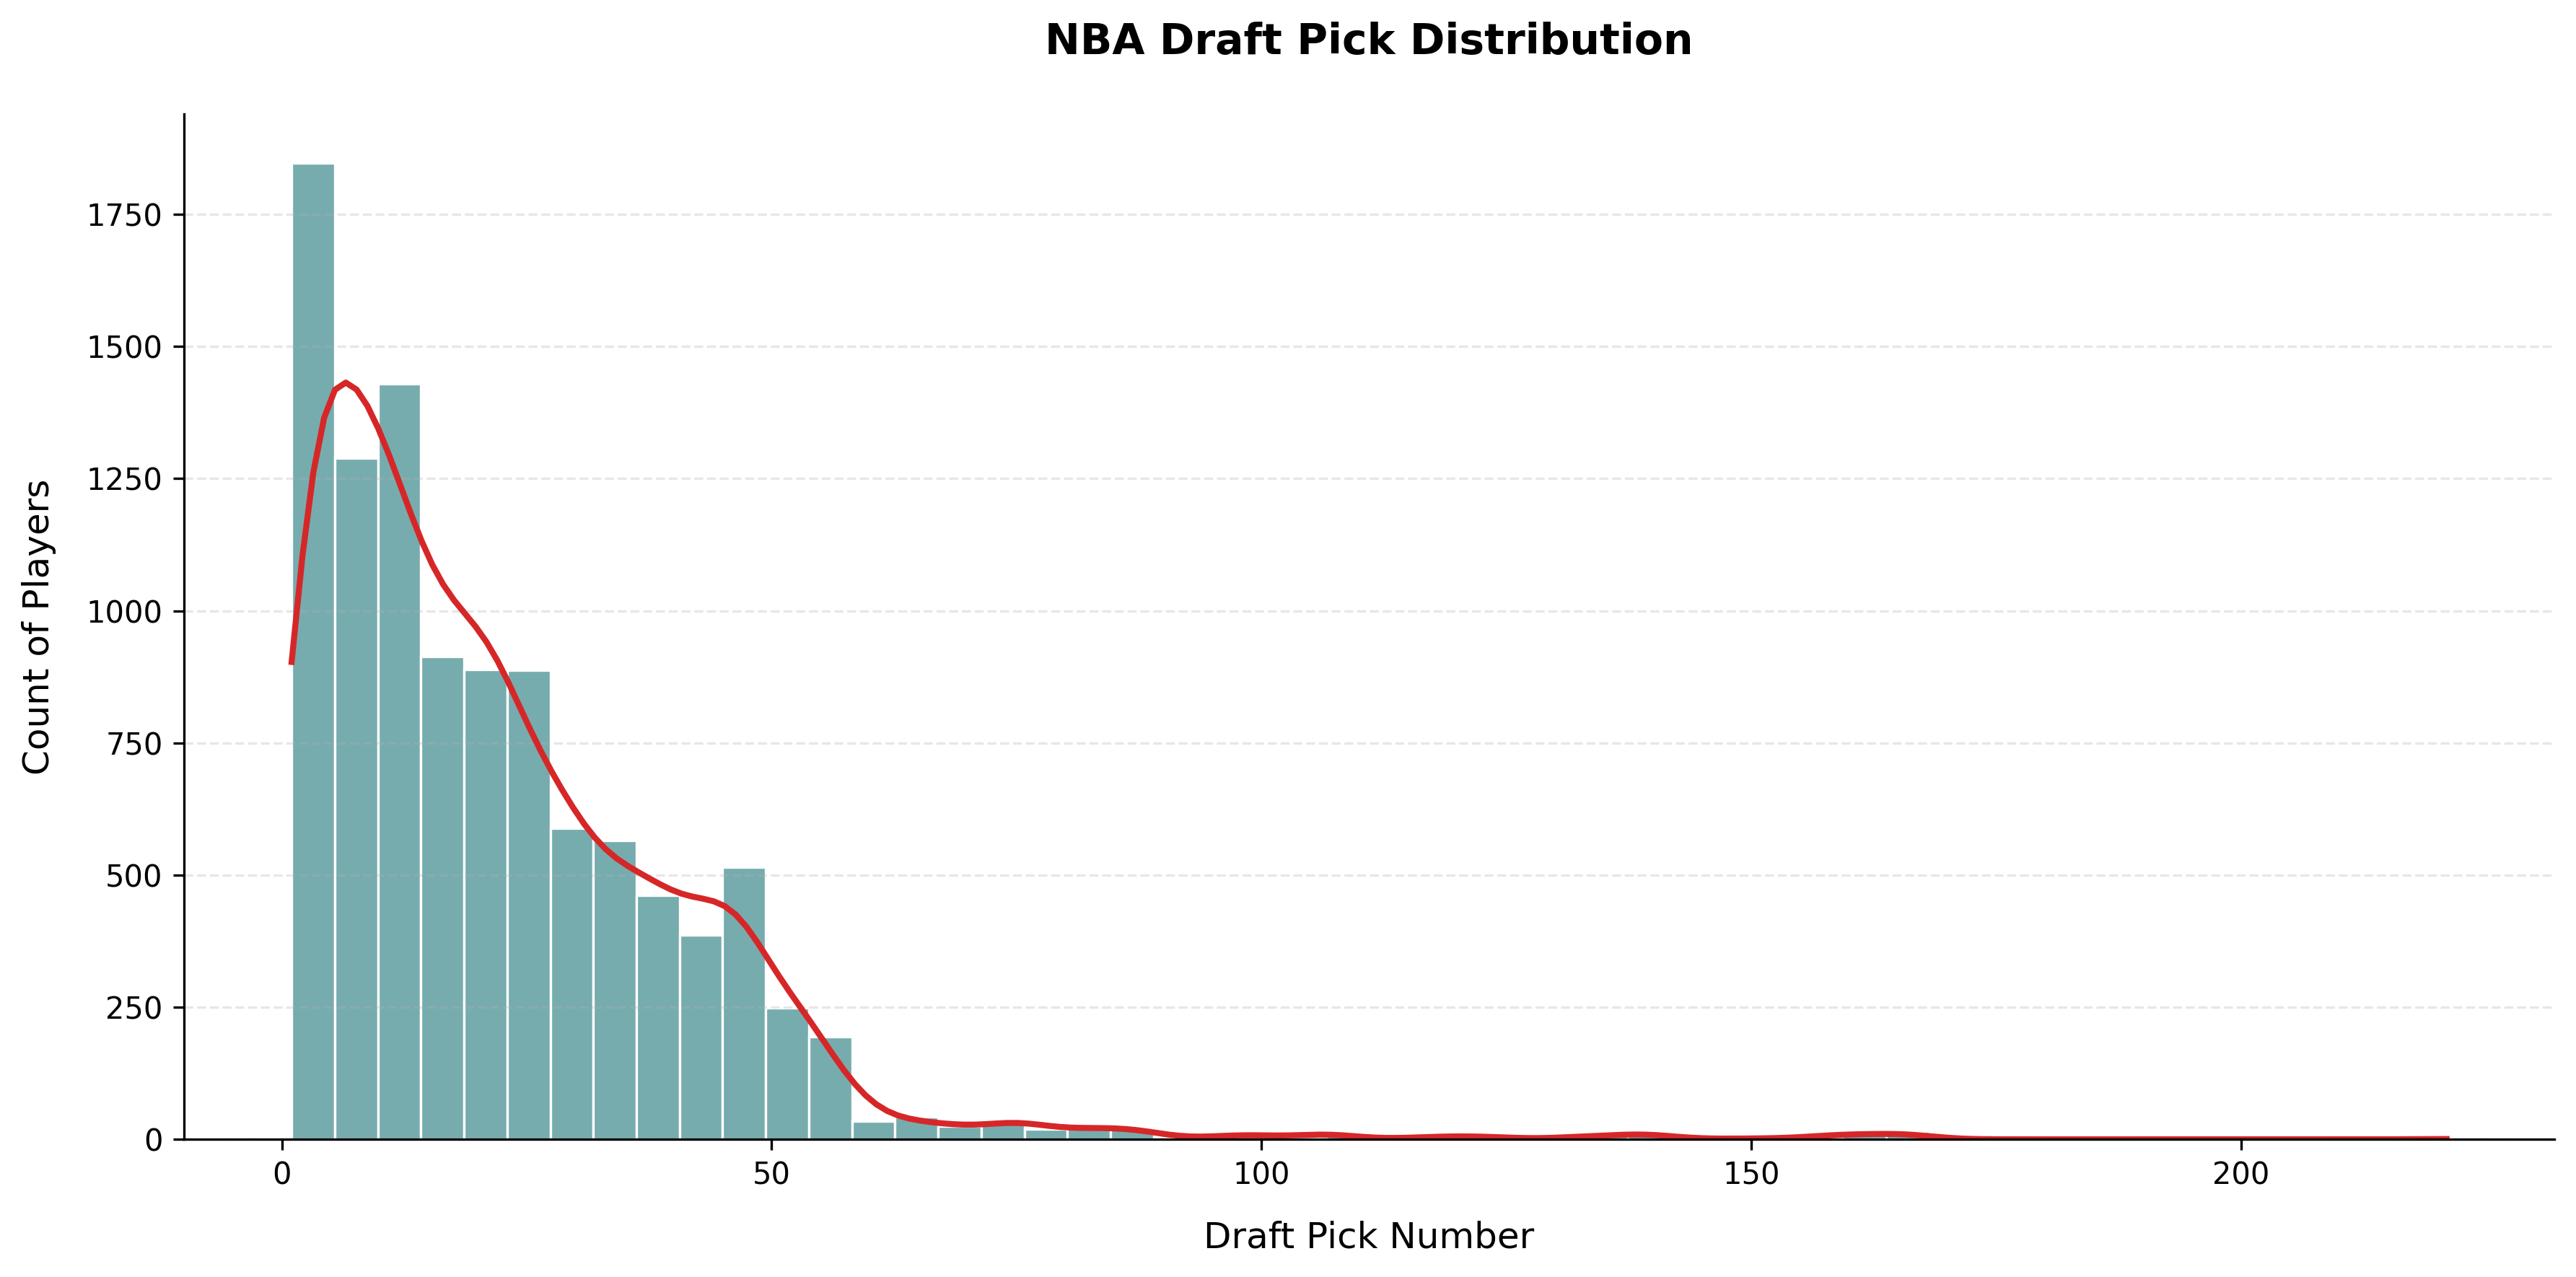

In [30]:
# Set up figure with improved proportions
plt.figure(figsize=(12, 6), facecolor='white')  # Wider aspect ratio

# Create histogram with refined styling
ax = sns.histplot(
    nba_salary_stats['draft_pick'],
    bins=50,
    kde=True,
    color='#5F9EA0',  # More sophisticated blue
    edgecolor='white',  # Clean bar edges
    linewidth=0.8,  # Subtle border
    alpha=0.85  # Slight transparency
)

# KDE line styling
for line in ax.lines:  # Access the KDE line
    line.set_color('#d62728')  # Contrasting red
    line.set_linewidth(2)  # Thicker line

# Customize labels with improved typography
plt.xlabel('Draft Pick Number', fontsize=12, labelpad=10, fontweight='normal')
plt.ylabel('Count of Players', fontsize=12, labelpad=10, fontweight='normal')
plt.title('NBA Draft Pick Distribution', 
          fontsize=14, pad=20, fontweight='bold')

# Improve tick marks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add light grid for better readability
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Remove top and right spines for cleaner look
sns.despine()

plt.tight_layout()
plt.show()

Correlation between height and three-point field goal

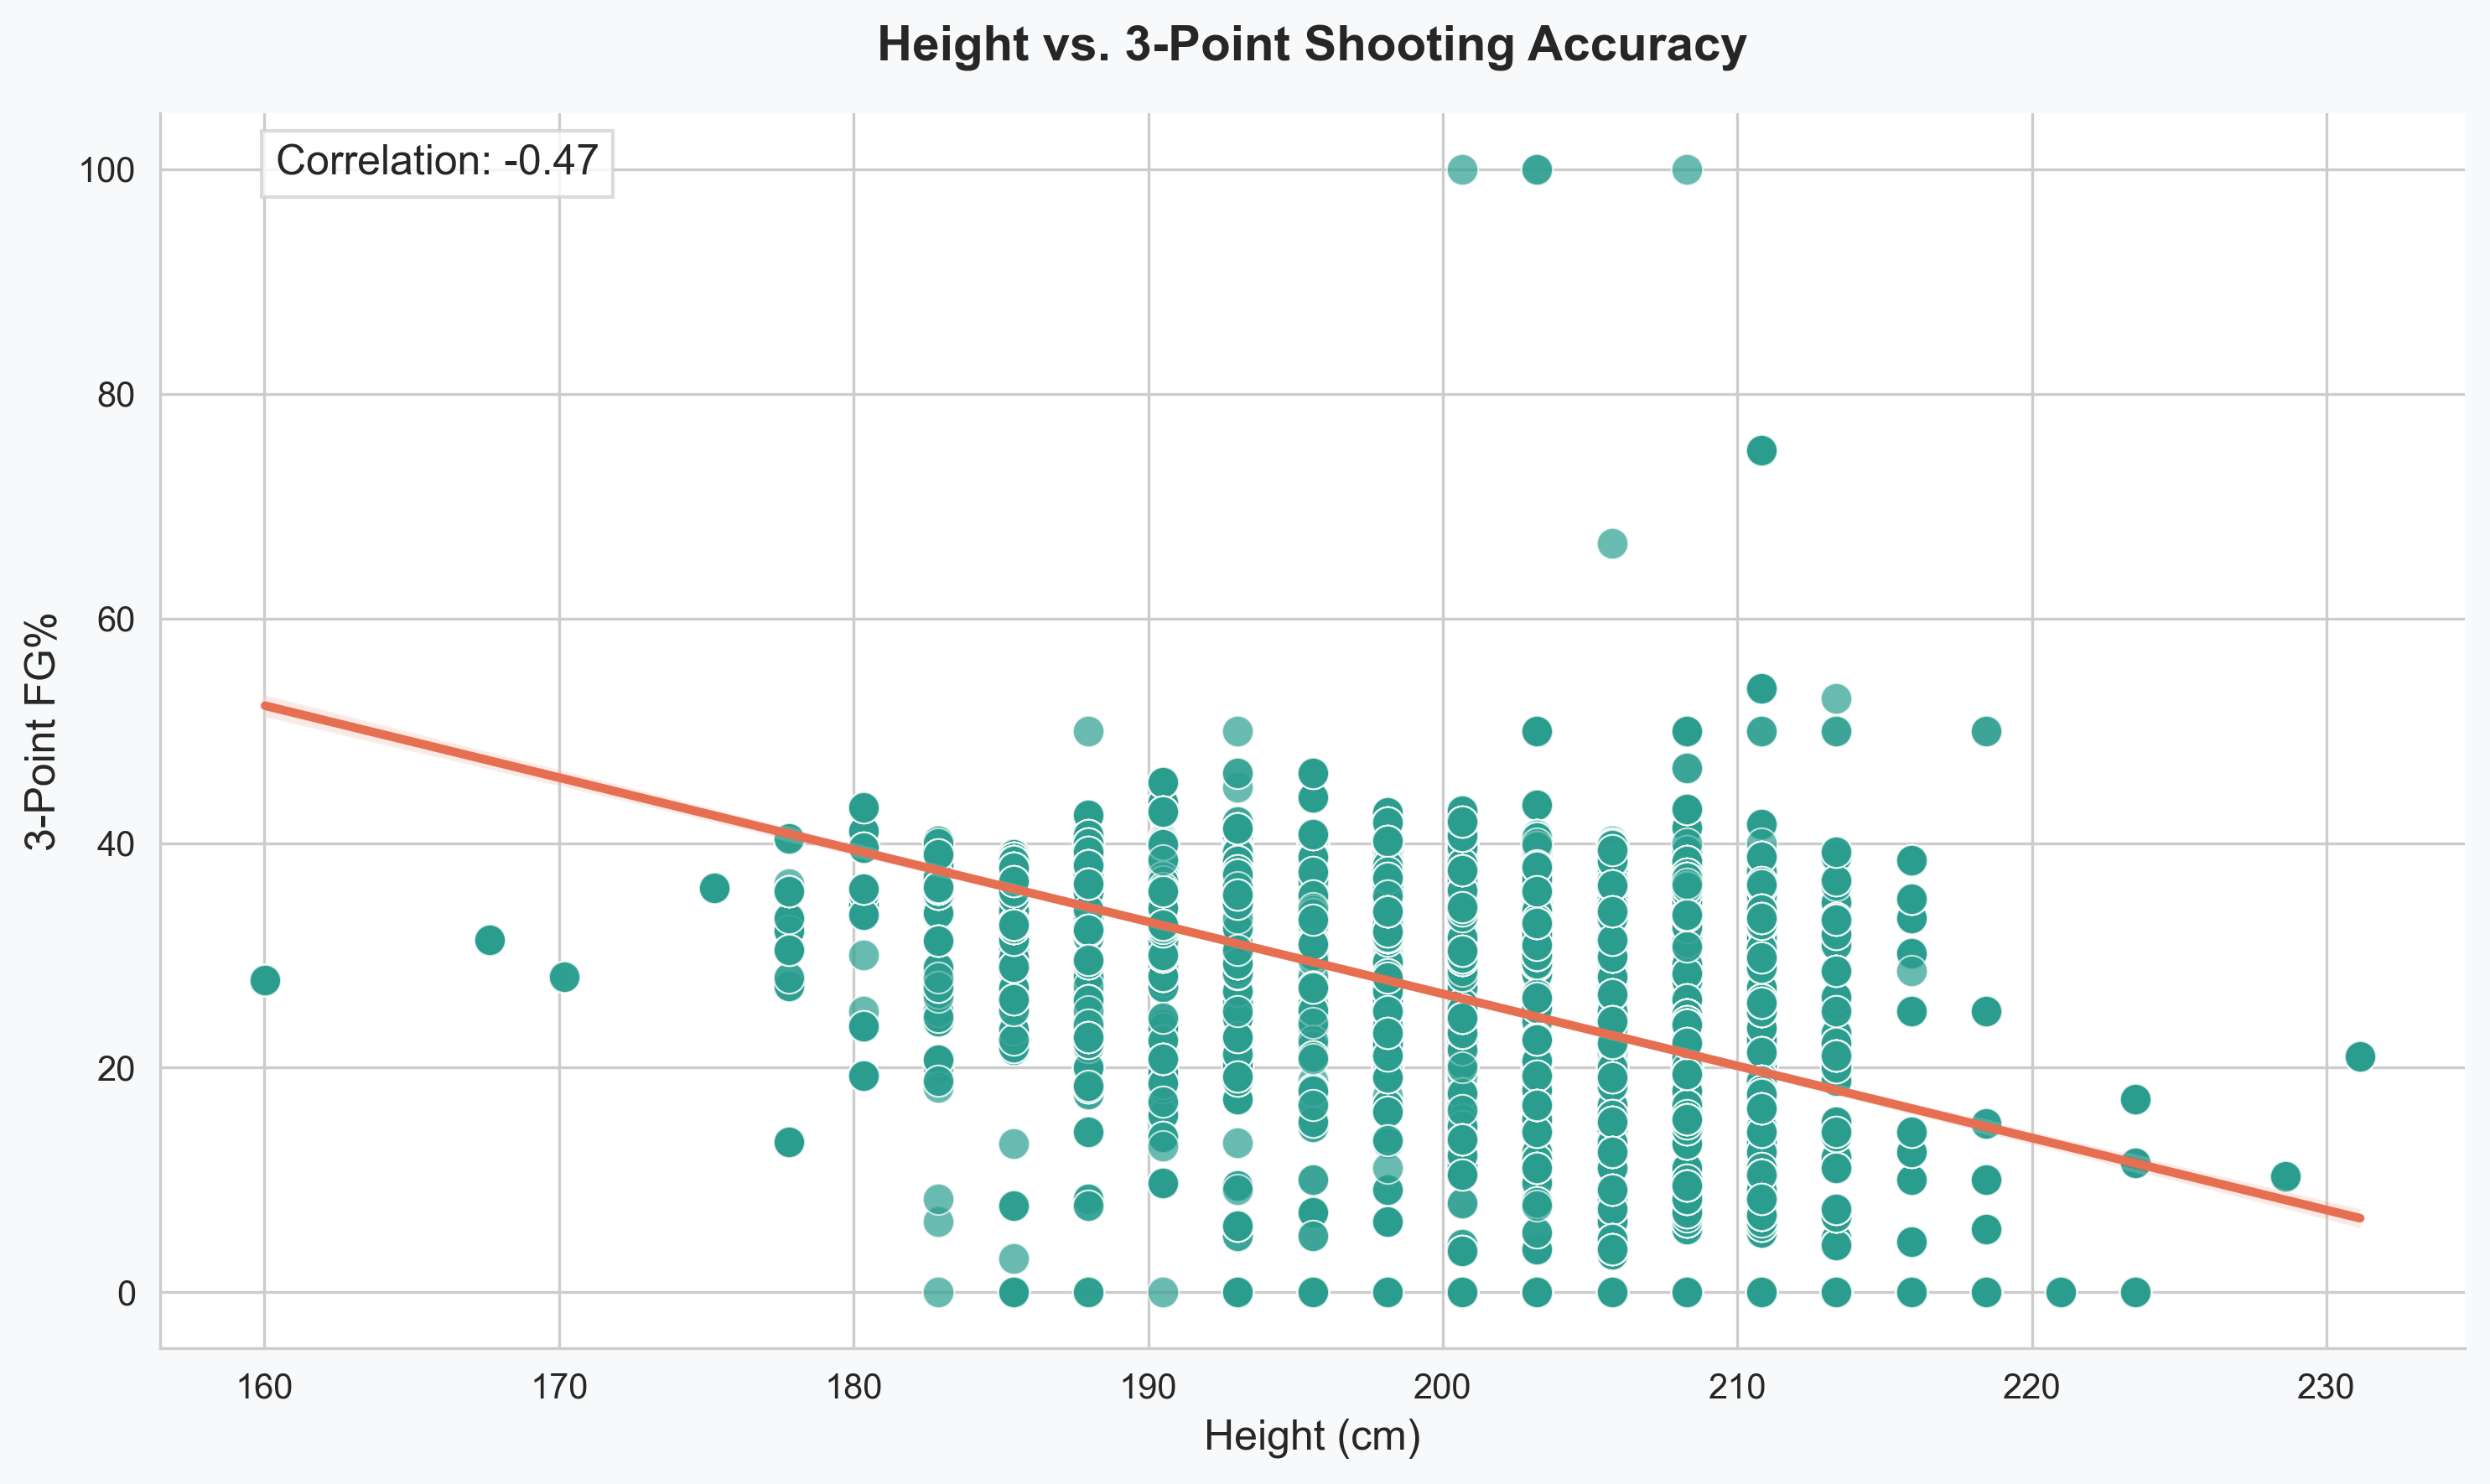

In [31]:
# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6), facecolor='#f8f9fa')

# Create scatter plot
scatter = sns.scatterplot(
    x='height',
    y='career_FG3%',
    data=nba_salary_stats,
    color='#2a9d8f',  # Attractive teal color
    alpha=0.7,
    s=80,  # Slightly larger points
    edgecolor='white',
    linewidth=0.5
)

# Add regression line
sns.regplot(
    x='height',
    y='career_FG3%',
    data=nba_salary_stats,
    scatter=False,
    color='#e76f51',  # Complementary coral color
    line_kws={'linewidth': 2.5}
)

# Calculate and display correlation
correlation = nba_salary_stats['height'].corr(nba_salary_stats['career_FG3%'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', 
         transform=plt.gca().transAxes,
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='lightgray'))

# Labels and title
plt.title('Height vs. 3-Point Shooting Accuracy', 
          fontsize=14, pad=15, fontweight='bold')
plt.xlabel('Height (cm)', fontsize=12)
plt.ylabel('3-Point FG%', fontsize=12)

# Adjust ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Clean up borders
sns.despine()

plt.tight_layout()
plt.show()

Is salary correlated with three-point field goal?

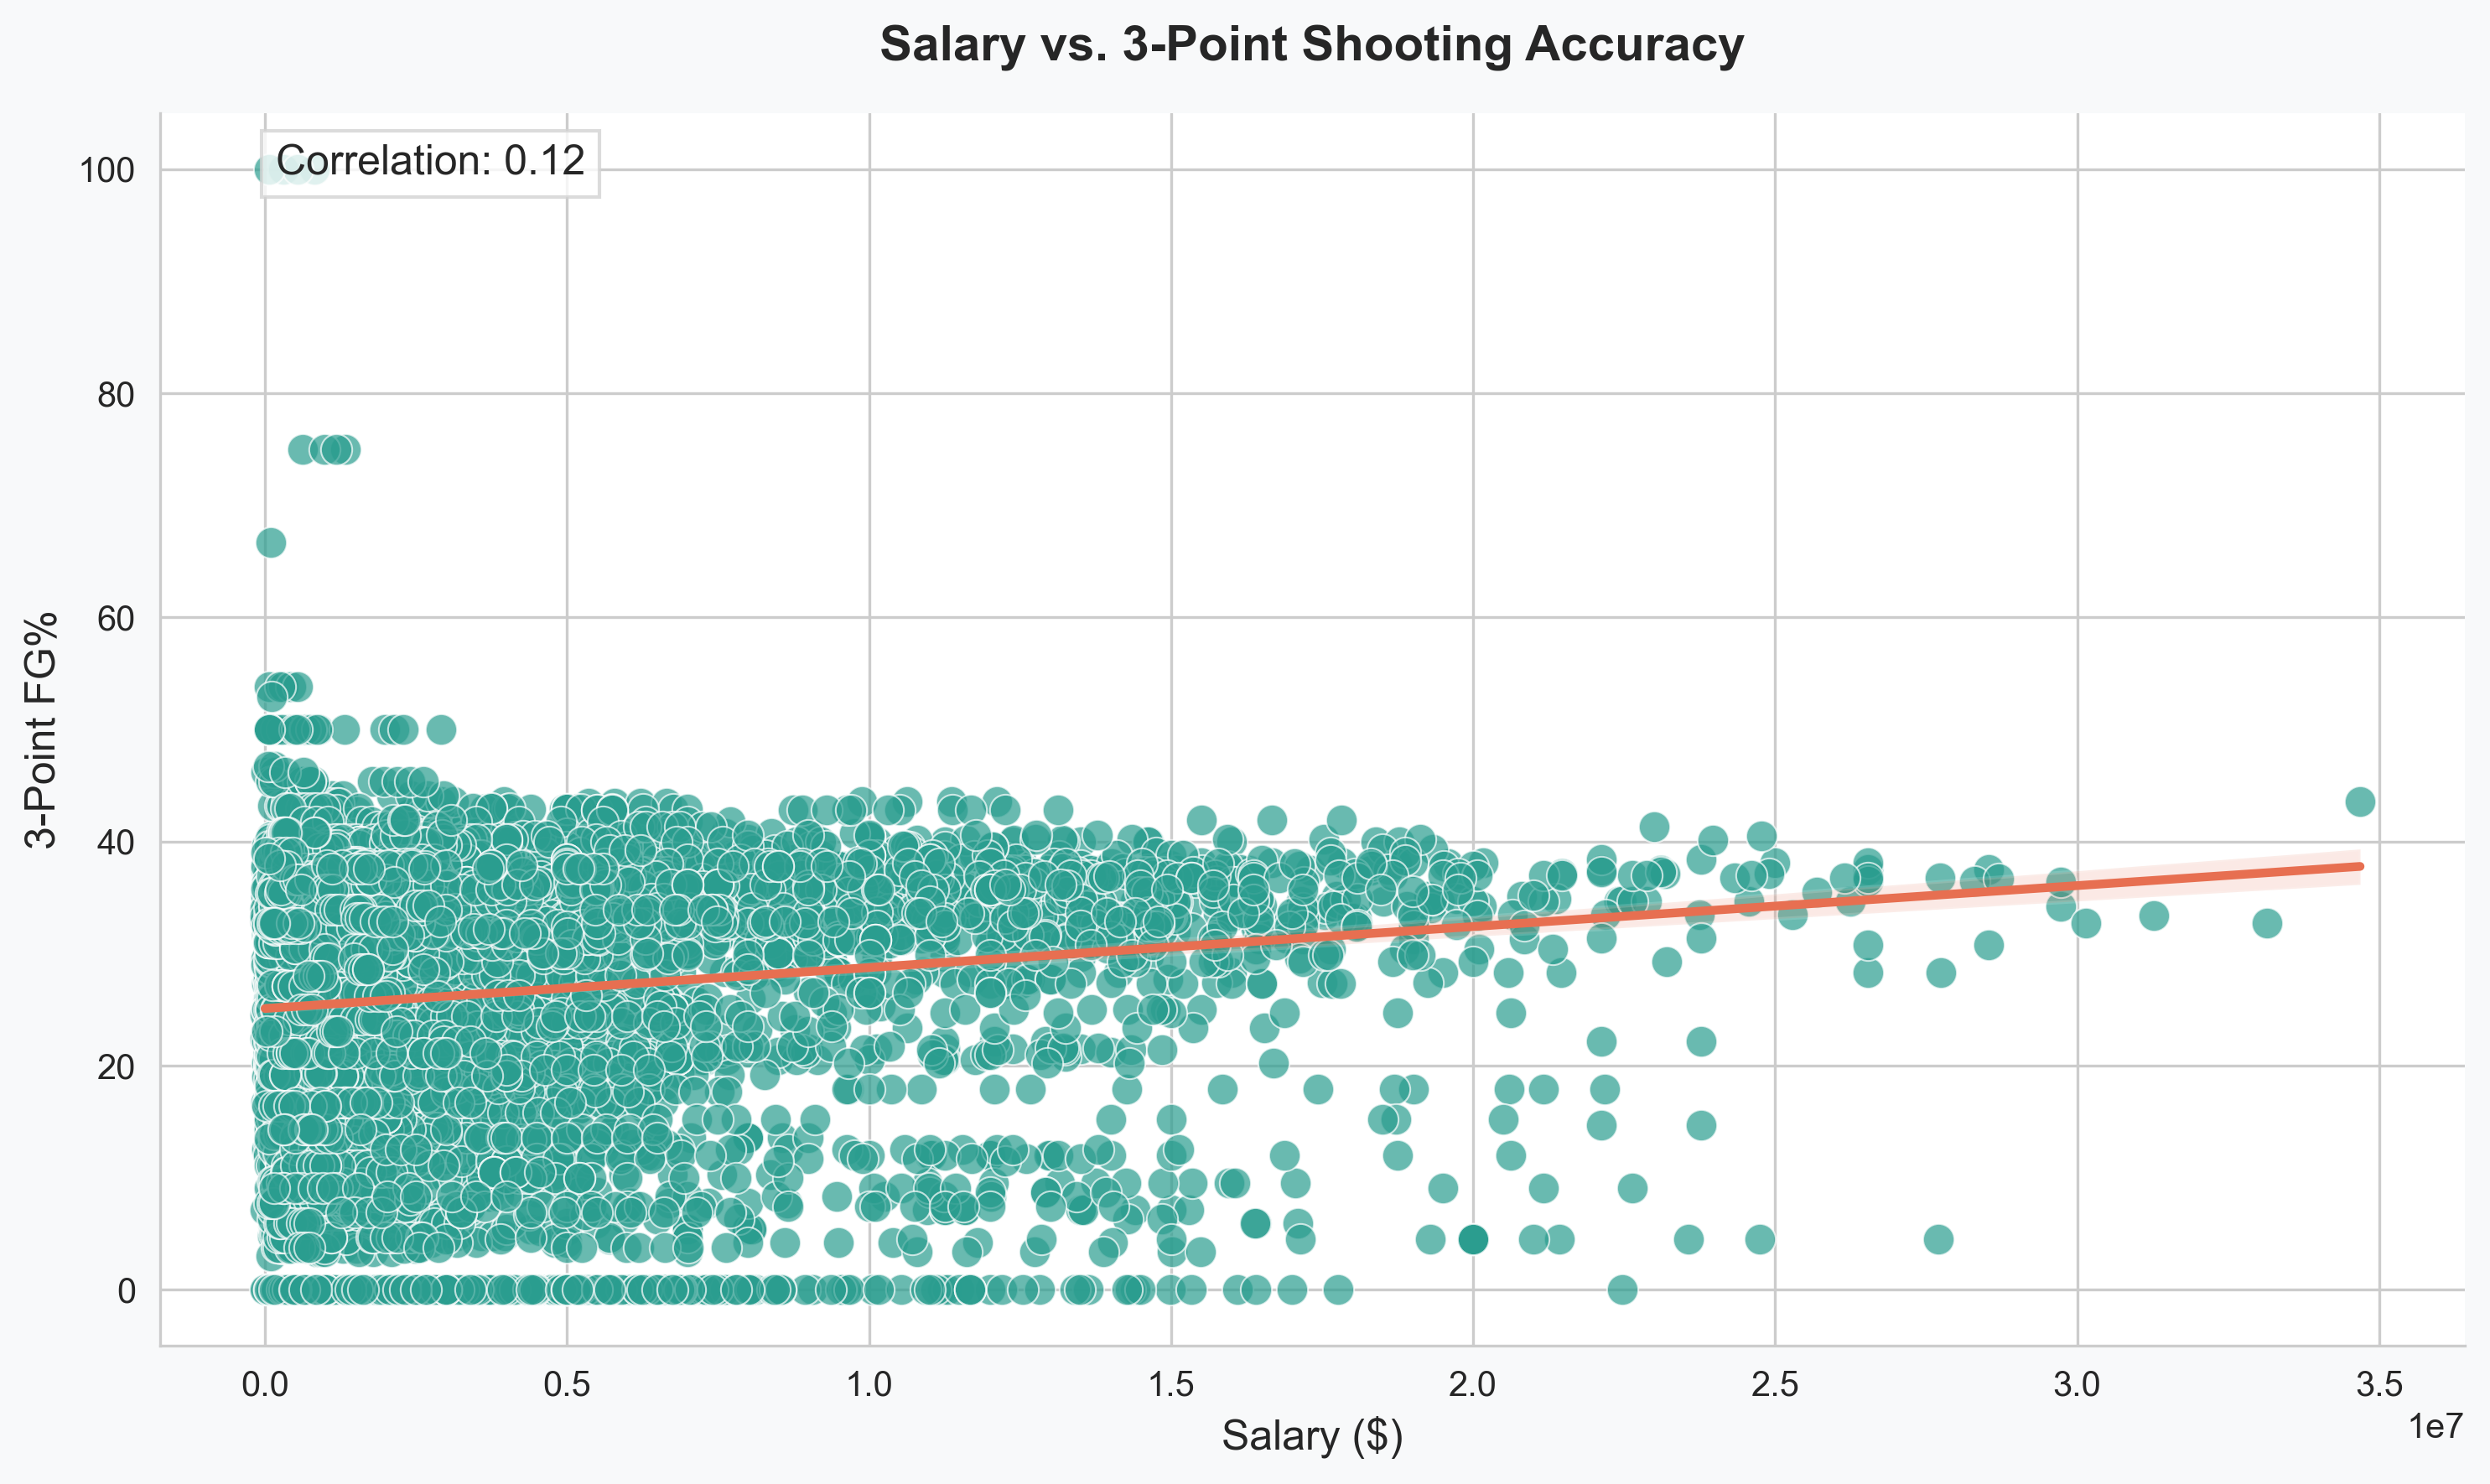

In [32]:
# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6), facecolor='#f8f9fa')

# Create scatter plot
scatter = sns.scatterplot(
    y='career_FG3%',
    x='salary',
    data=nba_salary_stats,
    color='#2a9d8f',  # Attractive teal color
    alpha=0.7,
    s=80,  # Slightly larger points
    edgecolor='white',
    linewidth=0.5
)

# Add regression line
sns.regplot(
    y='career_FG3%',
    x='salary',
    data=nba_salary_stats,
    scatter=False,
    color='#e76f51',  # Complementary coral color
    line_kws={'linewidth': 2.5}
)

# Calculate and display correlation
correlation = nba_salary_stats['salary'].corr(nba_salary_stats['career_FG3%'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', 
         transform=plt.gca().transAxes,
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='lightgray'))

# Labels and title
plt.title('Salary vs. 3-Point Shooting Accuracy', 
          fontsize=14, pad=15, fontweight='bold')
plt.xlabel('Salary ($)', fontsize=12)
plt.ylabel('3-Point FG%', fontsize=12)

# Adjust ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Clean up borders
sns.despine()

plt.tight_layout()
plt.show()

Bar chart of age at which the player was drafted:

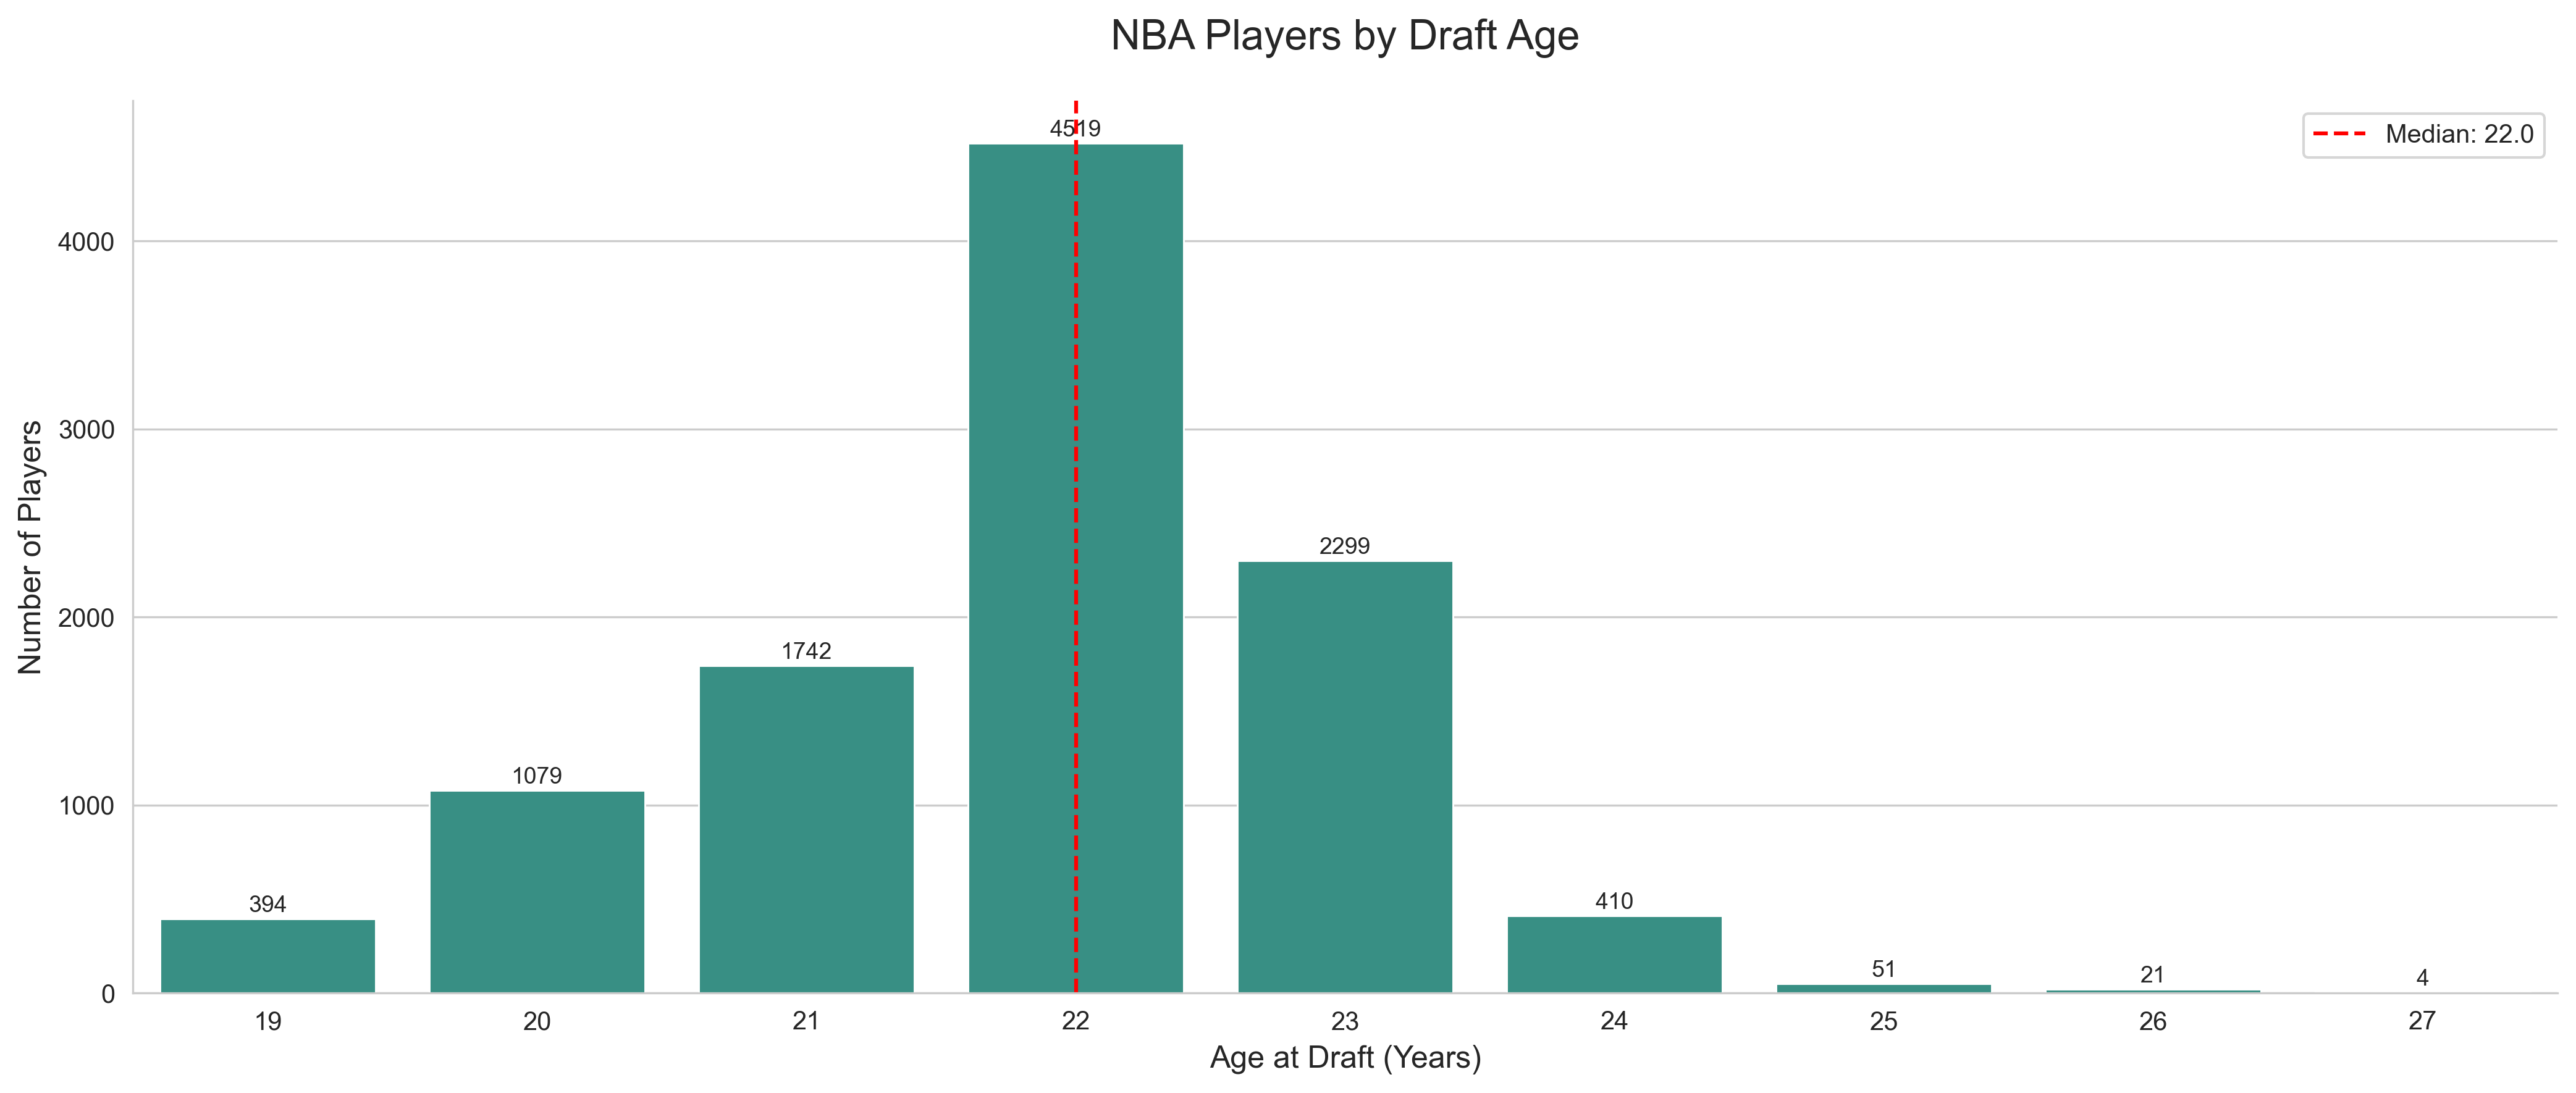

In [33]:
# Calculate and clean draft_age
positive_median = nba_salary_stats.loc[nba_salary_stats["draft_age"] > 0, "draft_age"].median()
nba_salary_stats["draft_age_clean"] = np.where(nba_salary_stats["draft_age"] < 0, 
                                             positive_median, 
                                             nba_salary_stats["draft_age"])

# Round ages to integers for clean bar labels
nba_salary_stats["draft_age_int"] = nba_salary_stats["draft_age_clean"].round().astype(int)

# Create countplot (bar chart)
plt.figure(figsize=(14, 6))
ax = sns.countplot(data=nba_salary_stats,
                 x="draft_age_int",
                 color="#2a9d8f",
                 edgecolor="white",
                 linewidth=0.7)

# Add median line
plt.axvline(x=positive_median - nba_salary_stats["draft_age_int"].min(), 
            color='red', 
            linestyle='--',
            linewidth=1.5,
            label=f'Median: {positive_median:.1f}')

# Customize
plt.title("NBA Players by Draft Age", fontsize=16, pad=20)
plt.xlabel("Age at Draft (Years)", fontsize=12)
plt.ylabel("Number of Players", fontsize=12)
plt.xticks(rotation=0)

# Add value labels on bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points',
                fontsize=9)

plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

In [34]:
nba_salary_stats["position"].value_counts()

position
Point Guard                                           1371
Center                                                1193
Shooting Guard                                         854
Power Forward and Center                               810
Small Forward                                          778
Center and Power Forward                               774
Power Forward                                          749
Point Guard and Shooting Guard                         668
Small Forward and Shooting Guard                       643
Shooting Guard and Small Forward                       560
Shooting Guard and Point Guard                         555
Power Forward and Small Forward                        550
Small Forward and Power Forward                        453
Small Forward and Center and Power Forward              68
Small Forward and Power Forward and Center              68
Small Forward and Shooting Guard and Power Forward      59
Shooting Guard and Small Forward and Point Guar

C:\Users\ZhouZhou\AppData\Local\Temp\ipykernel_5716\1345673545.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


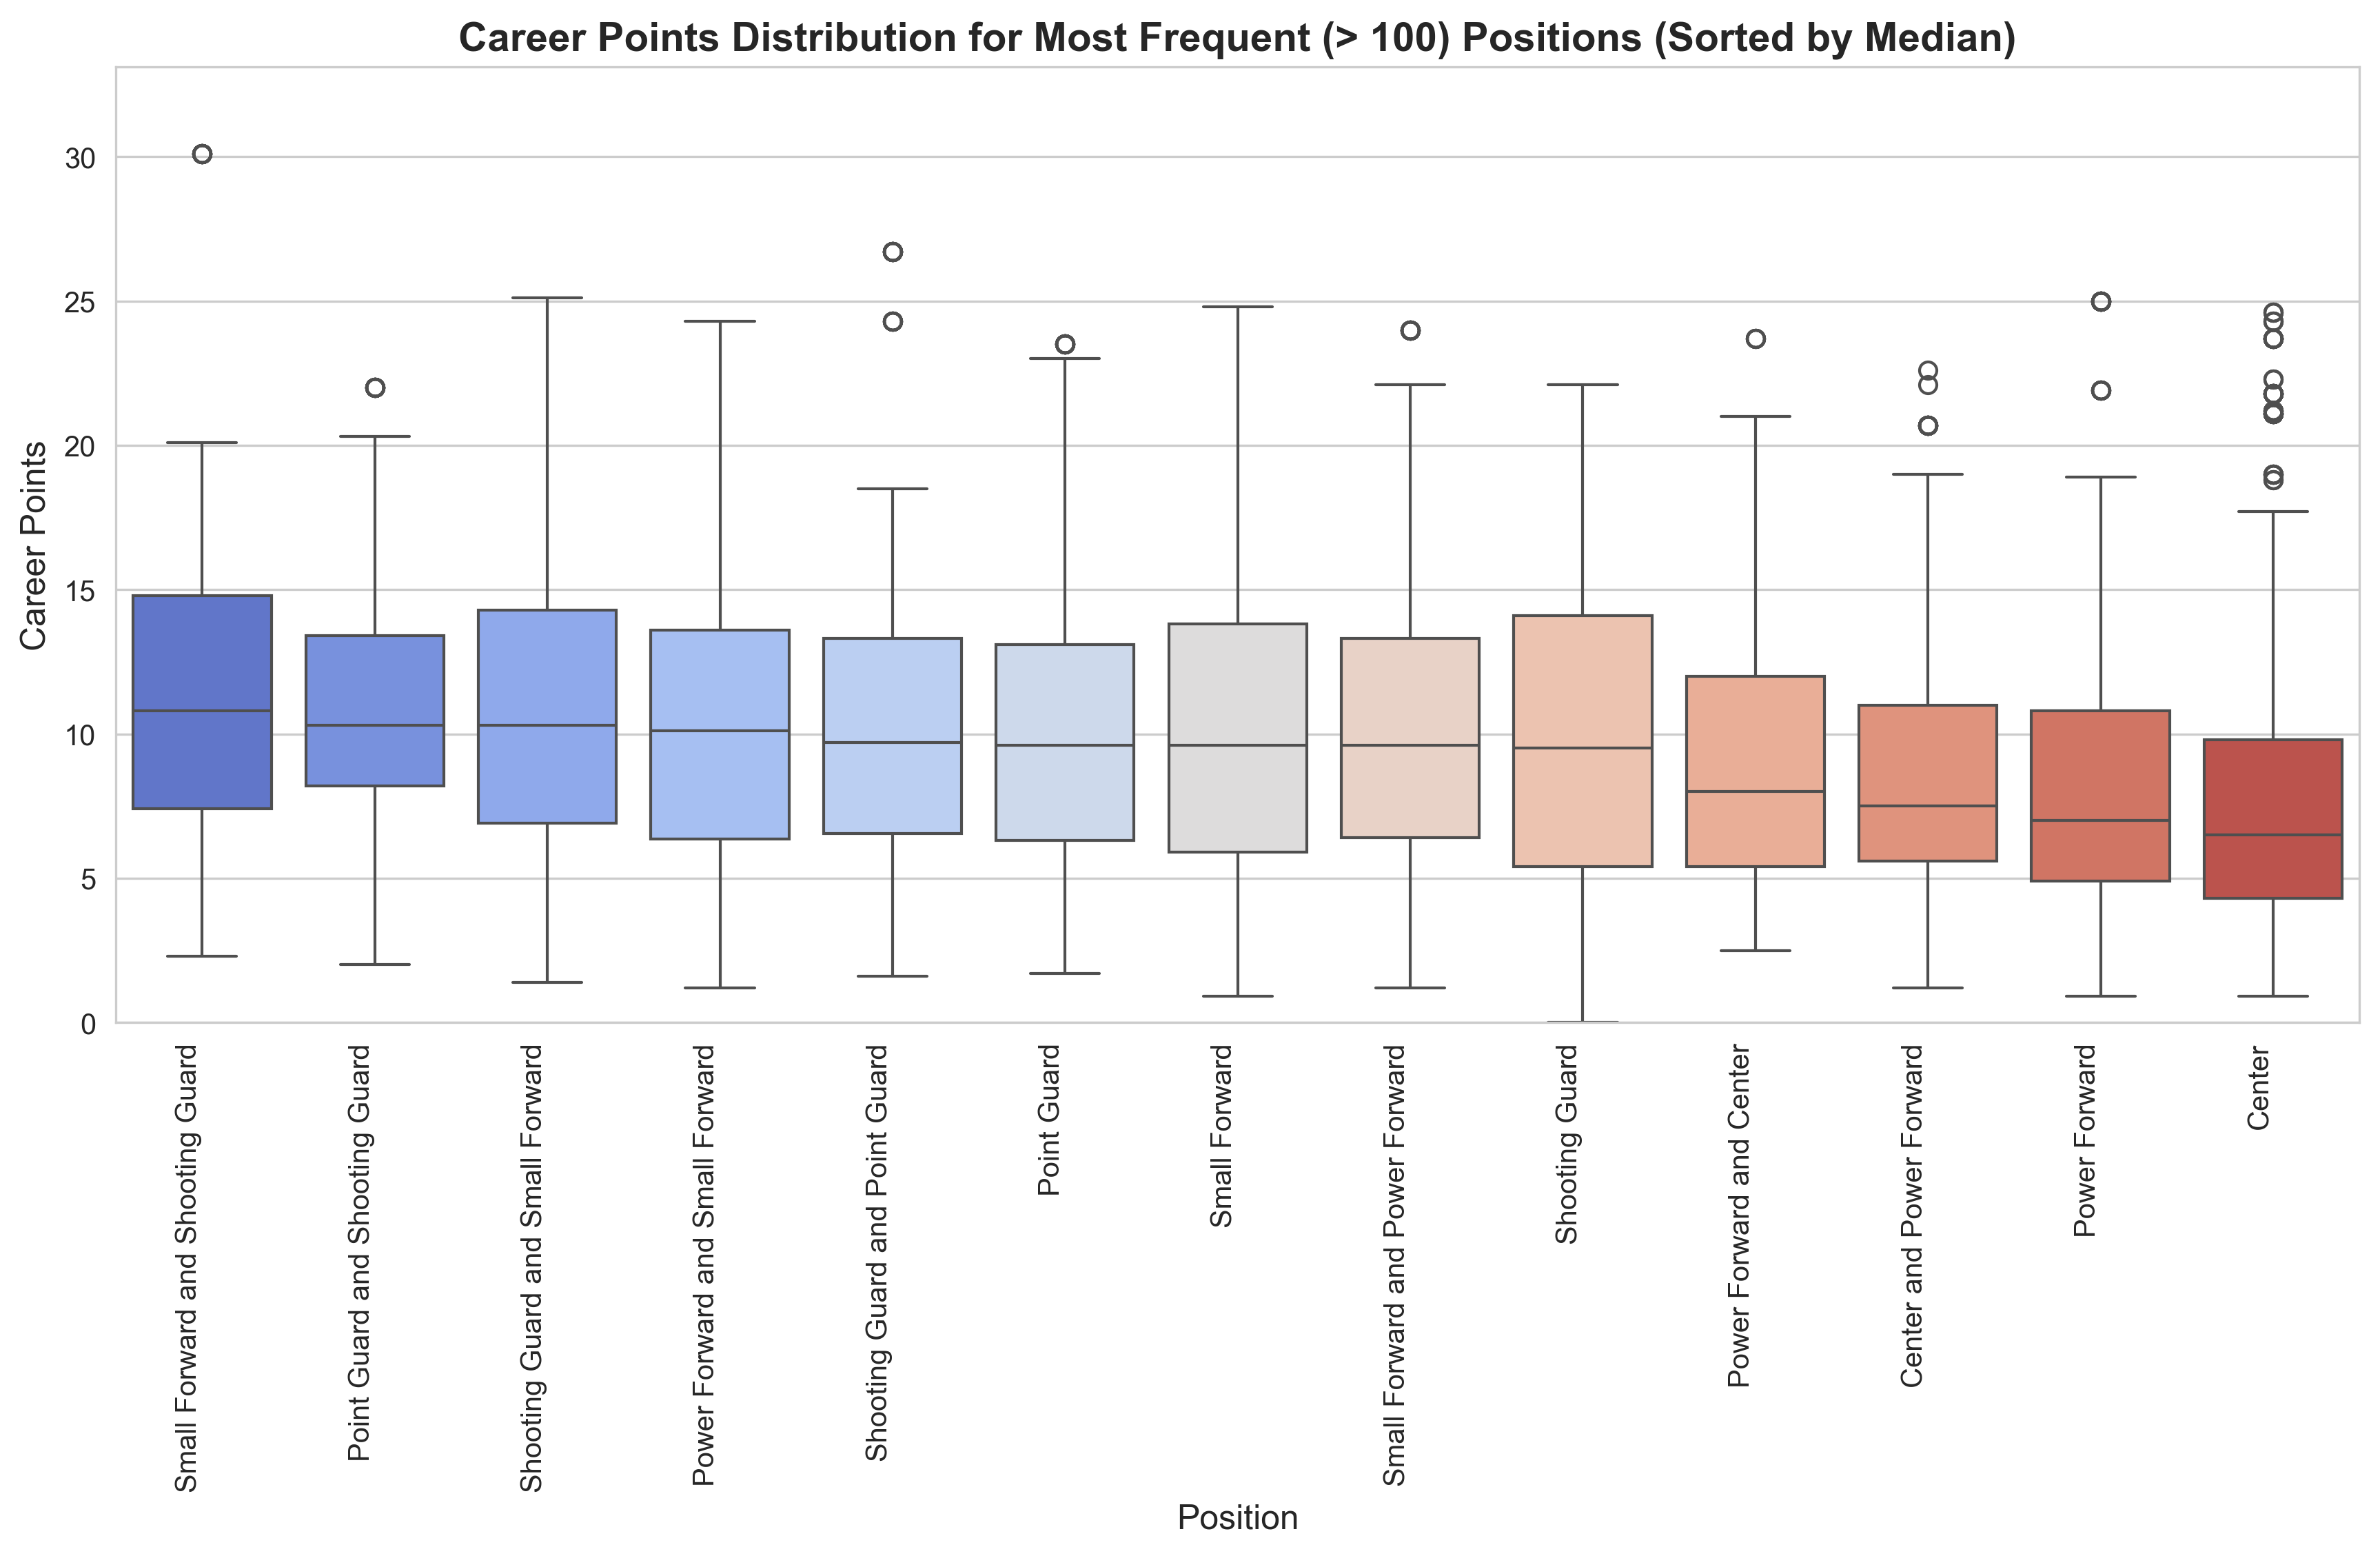

In [35]:
# Define the given positions
selected_positions = [
    "Center",
    "Point Guard",
    "Power Forward and Center",
    "Shooting Guard",
    "Small Forward",
    "Power Forward",
    "Center and Power Forward",
    "Small Forward and Shooting Guard",
    "Point Guard and Shooting Guard",
    "Shooting Guard and Point Guard",
    "Shooting Guard and Small Forward",
    "Power Forward and Small Forward",
    "Small Forward and Power Forward"
]

# Filter dataset for selected positions
filtered_data = nba_salary_stats[nba_salary_stats["position"].isin(selected_positions)]

# Compute median career points for each position and sort in descending order
sorted_positions = (
    filtered_data.groupby("position")["career_PTS"]
    .median()
    .sort_values(ascending=False)
    .index
)

# Set figure size and style
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

# Create a sorted boxplot
ax = sns.boxplot(
    x="position",
    y="career_PTS",
    data=filtered_data,
    order=sorted_positions,  # Sort positions based on median career points
    palette="coolwarm"
)

# Adjust y-axis limits dynamically based on data
plt.ylim(filtered_data["career_PTS"].min() * 0.9, filtered_data["career_PTS"].max() * 1.1)

# Customize labels and title
plt.xlabel("Position", fontsize=12)
plt.ylabel("Career Points", fontsize=12)
plt.title("Career Points Distribution for Most Frequent (> 100) Positions (Sorted by Median)", fontsize=14, fontweight="bold")

# Rotate x-axis labels to prevent overlap
plt.xticks(rotation=90, ha="right")

# Show the plot
plt.show()

Salary vs. Career Points Scatterplot:

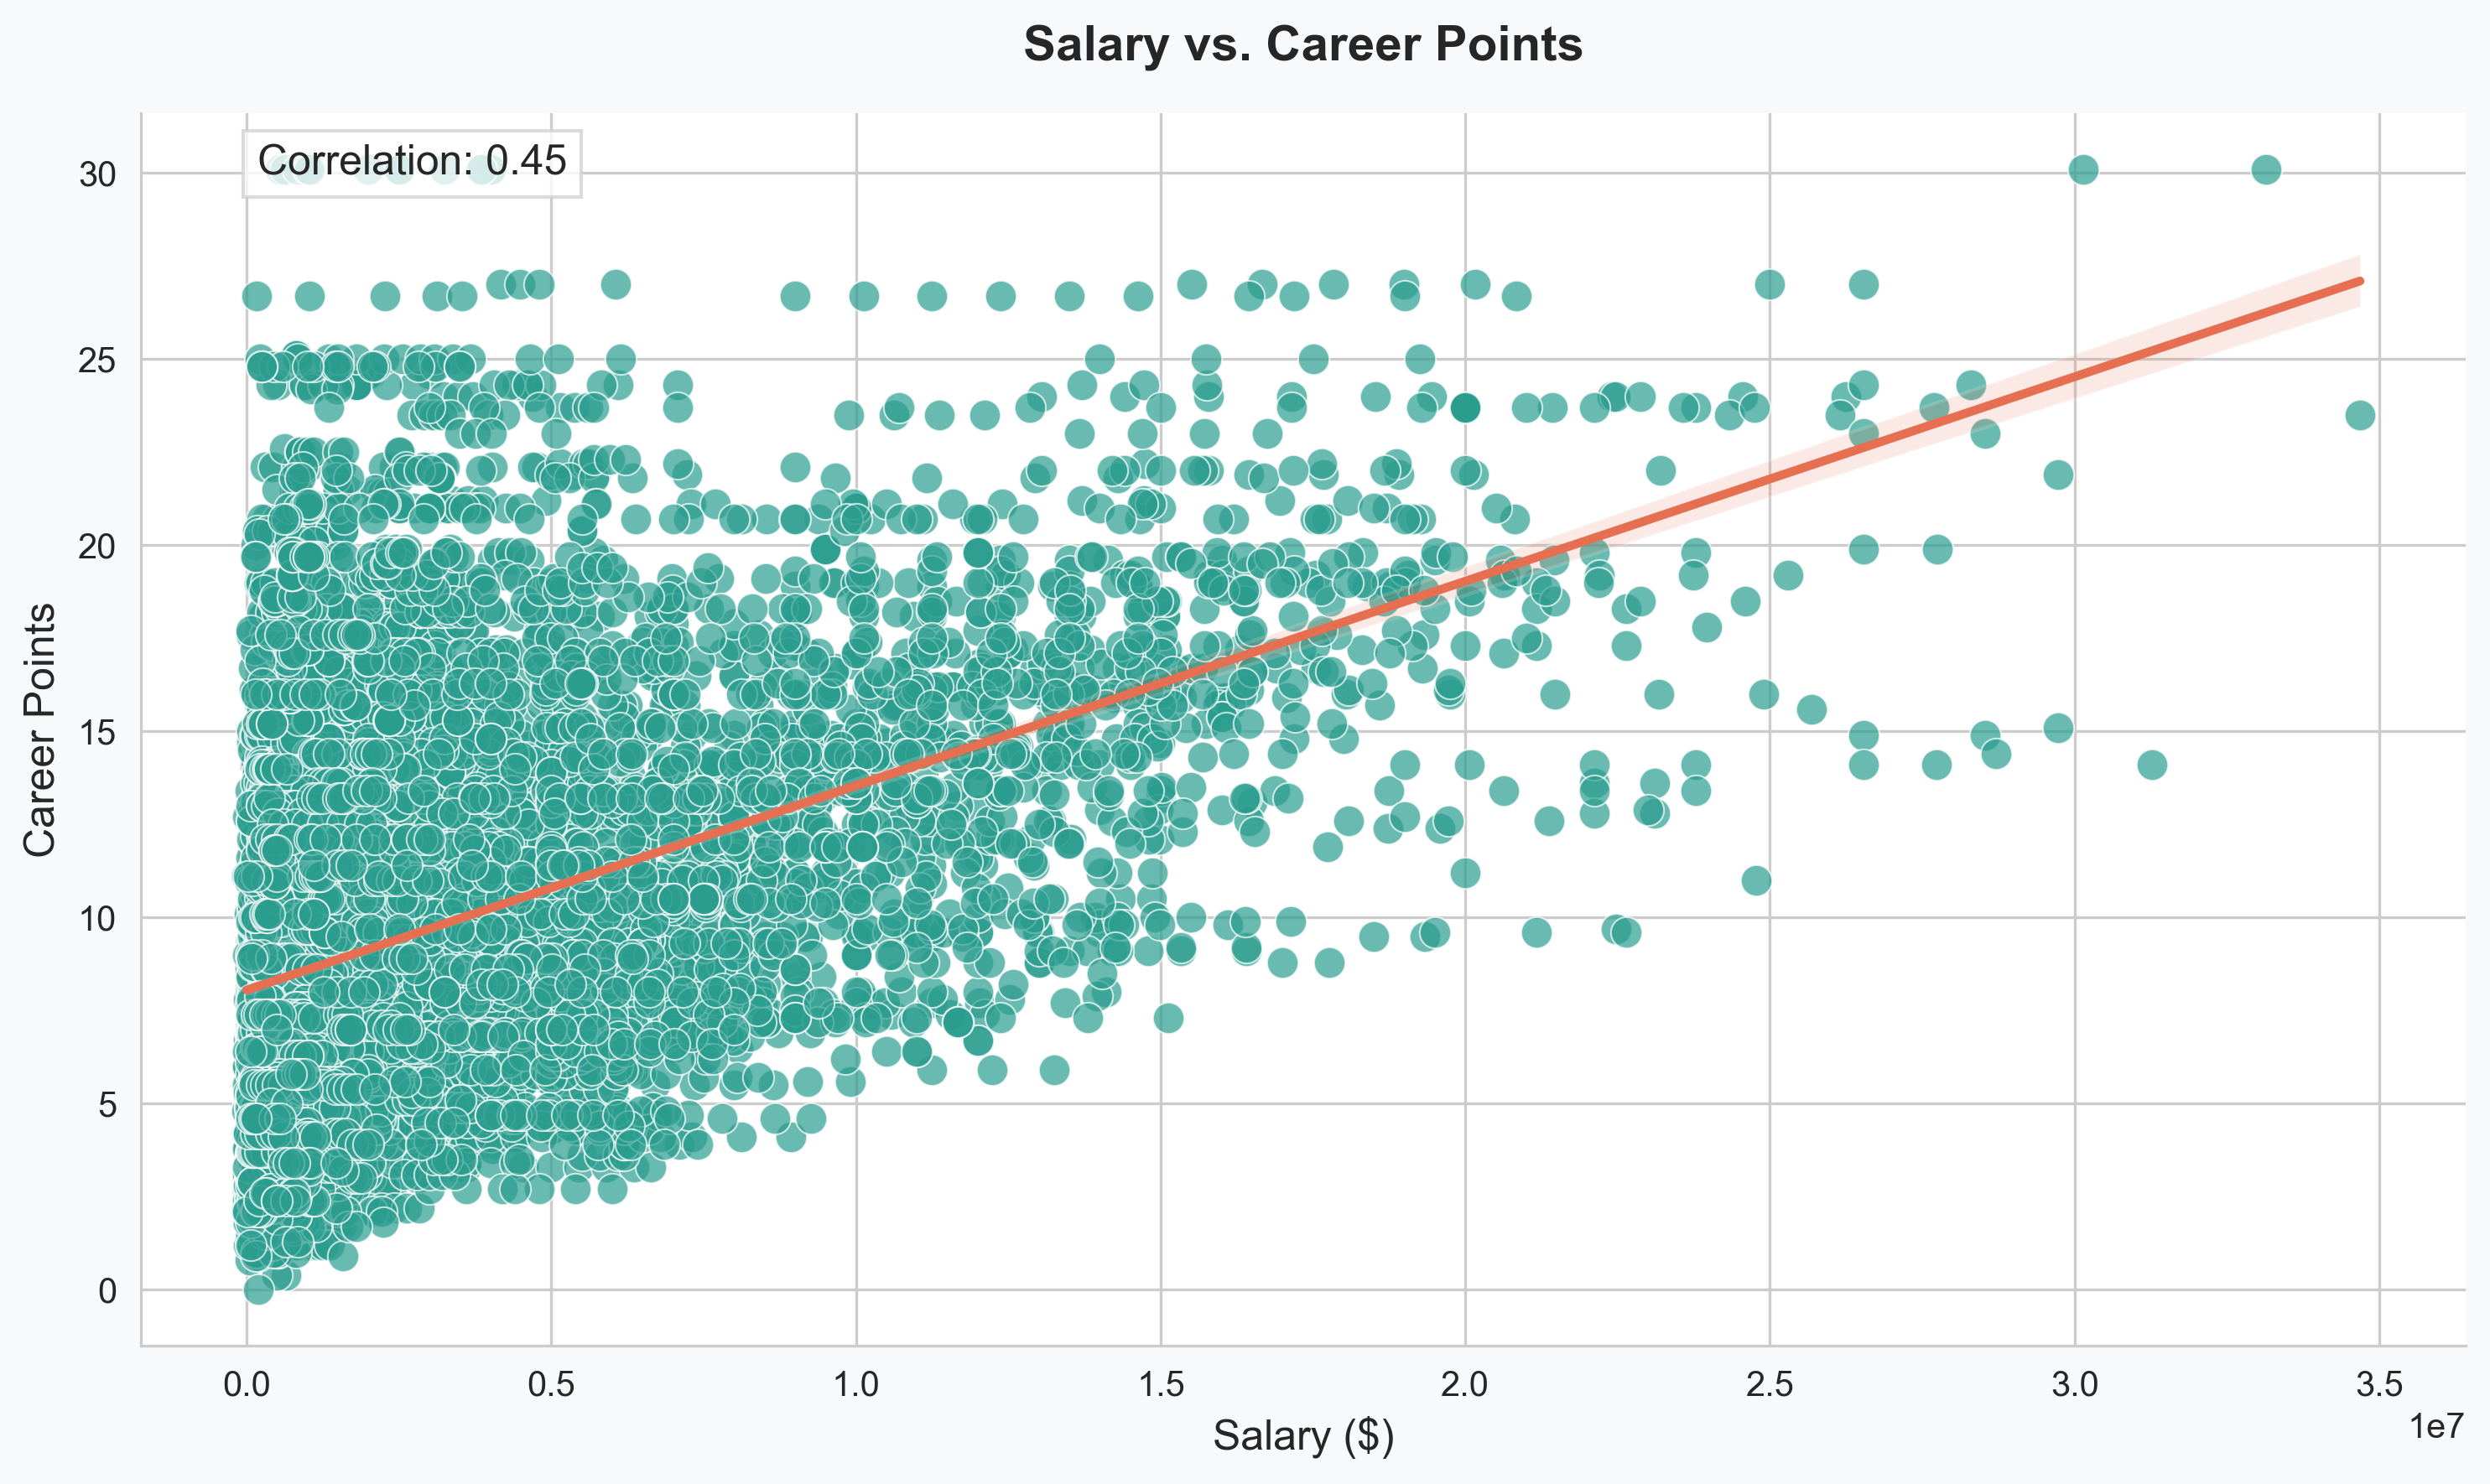

In [36]:
# Set style (unchanged)
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6), facecolor='#f8f9fa')

# Create scatter plot (only changed y-axis variable)
scatter = sns.scatterplot(
    x='salary',
    y='career_PTS',  # Changed from career_FG3%
    data=nba_salary_stats,
    color='#2a9d8f',  # Original teal color
    alpha=0.7,
    s=80,
    edgecolor='white',
    linewidth=0.5
)

# Add regression line (only changed y-axis variable)
sns.regplot(
    x='salary',
    y='career_PTS',  # Changed from career_FG3%
    data=nba_salary_stats,
    scatter=False,
    color='#e76f51',  # Original coral color
    line_kws={'linewidth': 2.5}
)

# Calculate and display correlation (changed variables)
correlation = nba_salary_stats['salary'].corr(nba_salary_stats['career_PTS'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', 
         transform=plt.gca().transAxes,
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='lightgray'))

# Labels and title (only text changed)
plt.title('Salary vs. Career Points',  # Changed title
          fontsize=14, pad=15, fontweight='bold')
plt.xlabel('Salary ($)', fontsize=12)  # Kept same
plt.ylabel('Career Points', fontsize=12)  # Changed from 3-Point FG%

# Adjust ticks (unchanged)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Clean up borders (unchanged)
sns.despine()

plt.tight_layout()
plt.show()

Top 10 Positions by Average Salary (Bar Chart)

Shooting hand preference frequency table:

In [37]:
nba_salary_stats["shoots"].value_counts()

shoots
Right         9669
Left           843
Left Right       7
Name: count, dtype: int64

### Feature Engineering

Checking data shape before removing the outliers:

In [38]:
print(f"Dataset has {nba_salary_stats.shape[0]} rows and {nba_salary_stats.shape[1]} columns.")

Dataset has 10519 rows and 36 columns.


Custom function to remove the outliers:

Drop unneeded columns:

In [39]:
nba_salary_stats.columns

Index(['league', 'player_id', 'salary', 'season', 'season_end', 'season_start',
       'team', 'index', 'birthDate', 'birthPlace', 'career_AST', 'career_FG%',
       'career_FG3%', 'career_FT%', 'career_G', 'career_PER', 'career_PTS',
       'career_TRB', 'career_WS', 'career_eFG%', 'college', 'draft_pick',
       'draft_round', 'draft_team', 'draft_year', 'height', 'highSchool',
       'name', 'position', 'shoots', 'weight', 'birth_city', 'nationality',
       'draft_age', 'draft_age_clean', 'draft_age_int'],
      dtype='object')

In [40]:
nba_salary_stats.drop(columns=["league", "player_id", "season", "season_end", 
                               "index", "birthDate", "birthPlace", "career_TRB",
                               "career_eFG%", "college", "draft_pick", "name",
                               "draft_team", "draft_round", "draft_year",
                               "highSchool", "birth_city", "nationality",
                               "draft_age_clean", "draft_age_int"], inplace=True)

New columns:

In [41]:
nba_salary_stats.columns

Index(['salary', 'season_start', 'team', 'career_AST', 'career_FG%',
       'career_FG3%', 'career_FT%', 'career_G', 'career_PER', 'career_PTS',
       'career_WS', 'height', 'position', 'shoots', 'weight', 'draft_age'],
      dtype='object')

Correlation Matrix:

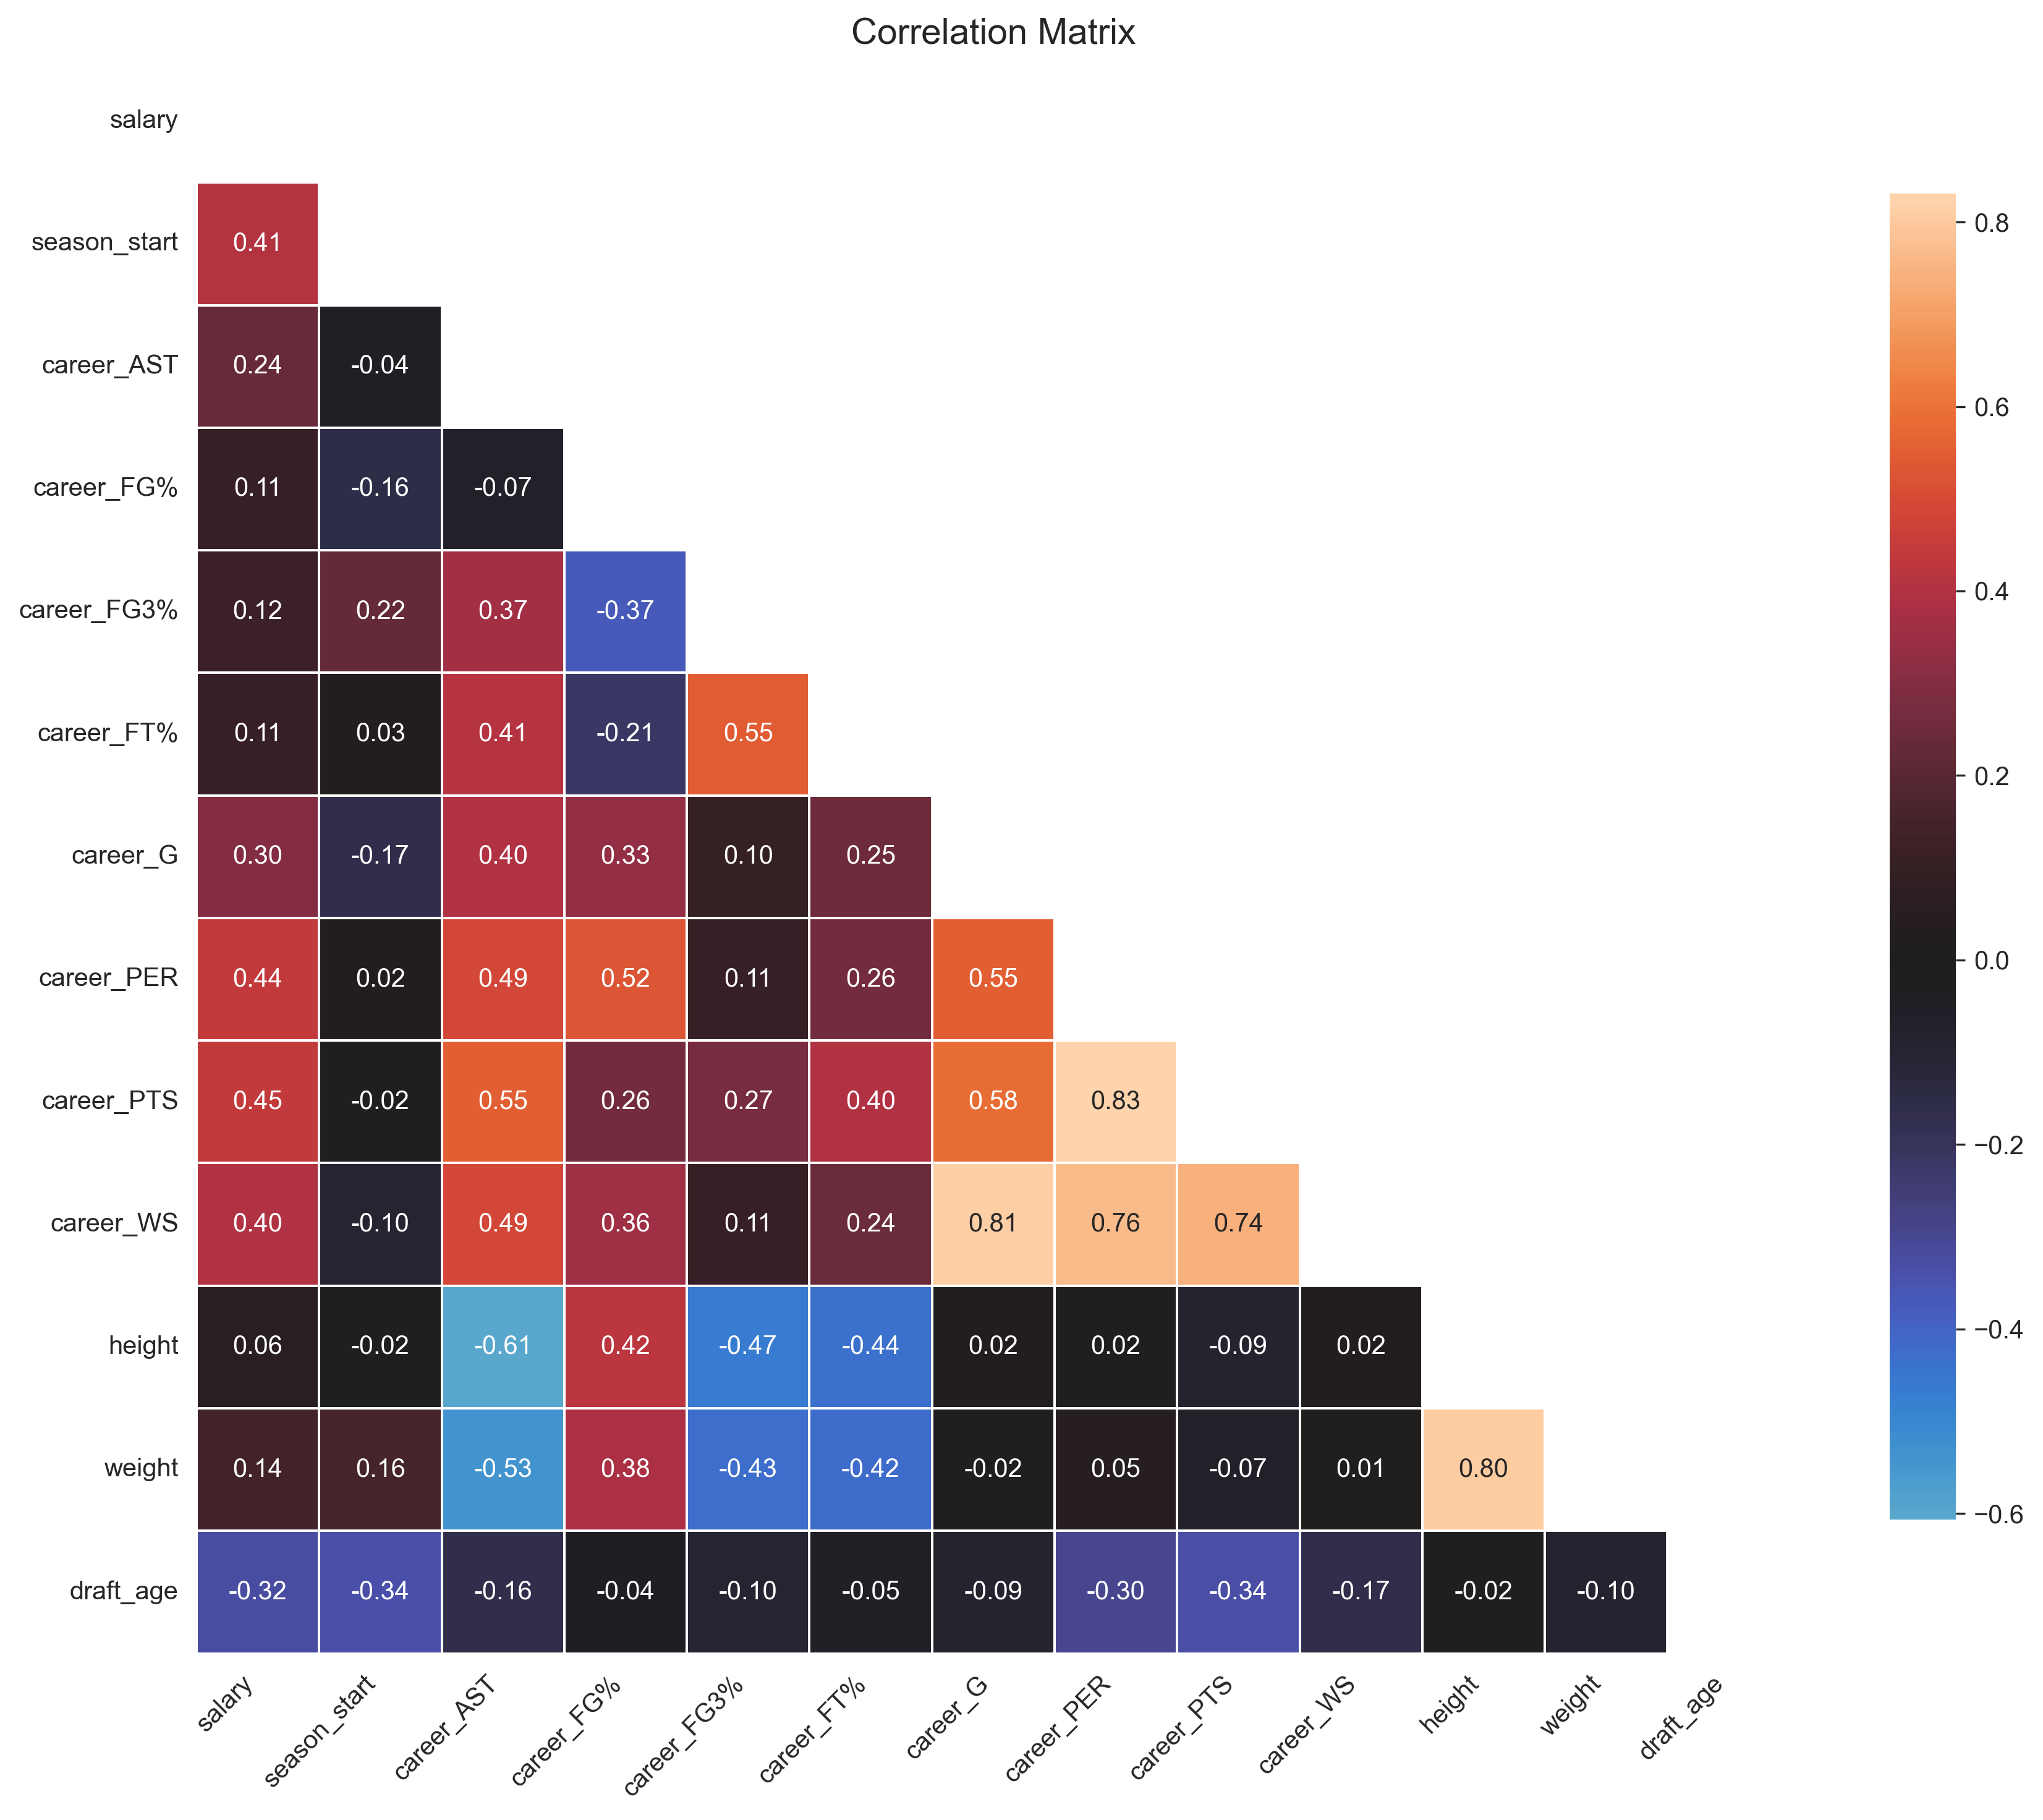

In [42]:
# Calculate correlation matrix
corr_matrix = nba_salary_stats.corr(numeric_only=True)

# Create mask for diagonal AND upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) | np.eye(corr_matrix.shape[0], dtype=bool)

# Plot heatmap (shows only lower triangle, no diagonal)
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    mask=mask,  # Hide diagonal + upper triangle
    annot=True,
    fmt=".2f",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.grid(False)
plt.title("Correlation Matrix", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Select highly correlated features (above 50%) and remove multicollinearity: 

In [43]:
# Calculate correlation matrix
corr_matrix = nba_salary_stats.corr(numeric_only=True).abs()

# Get upper triangle to avoid duplicates
upper_triangle = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Find high correlations (≥50%)
high_corr_pairs = (
    corr_matrix
    .where(upper_triangle)
    .stack()
    .loc[lambda x: (x >= 0.5) & (x < 1.0)]
    .reset_index()
    .rename(columns={'level_0': 'Feature_A', 'level_1': 'Feature_B', 0: 'Correlation'})
)

def select_feature(row):
    """Select feature with higher correlation to salary"""
    corr_a = corr_matrix.loc[row["Feature_A"], "salary"]
    corr_b = corr_matrix.loc[row["Feature_B"], "salary"]
    return row["Feature_A"] if corr_a > corr_b else row["Feature_B"]

# Apply selection
high_corr_pairs["Selected_Feature"] = high_corr_pairs.apply(select_feature, axis=1)

# Get final selected features
selected_features = high_corr_pairs["Selected_Feature"].unique()

print("Highly correlated feature pairs (≥50%):")
print(high_corr_pairs[['Feature_A', 'Feature_B', 'Correlation', 'Selected_Feature']])

print("\nSelected features (higher correlation with salary):")
print(selected_features)

Highly correlated feature pairs (≥50%):
      Feature_A   Feature_B  Correlation Selected_Feature
0    career_AST  career_PTS     0.551707       career_PTS
1    career_AST      height     0.606895       career_AST
2    career_AST      weight     0.534443       career_AST
3    career_FG%  career_PER     0.522537       career_PER
4   career_FG3%  career_FT%     0.547832      career_FG3%
5      career_G  career_PER     0.554679       career_PER
6      career_G  career_PTS     0.584422       career_PTS
7      career_G   career_WS     0.812898        career_WS
8    career_PER  career_PTS     0.830781       career_PTS
9    career_PER   career_WS     0.763526       career_PER
10   career_PTS   career_WS     0.742224       career_PTS
11       height      weight     0.803233           weight

Selected features (higher correlation with salary):
['career_PTS' 'career_AST' 'career_PER' 'career_FG3%' 'career_WS' 'weight']


## Apply Machine Learning Models

Normalize and One Hot Encode
- One Hot Encode for `team`, `position`, `shoots`
- Normalize the remaining columns using `MinMaxScaler()`

In [44]:
ct = make_column_transformer(
    (MinMaxScaler(), ["season_start", "career_AST", "career_FG%", "career_FG3%", 
                      "career_FT%", "career_G", "career_PER", "career_PTS", "career_WS", 
                      "height", "weight", "draft_age"]), # Normalize these columns
    (OneHotEncoder(handle_unknown="ignore"), ["team", "position", "shoots"]) # One hot encode these columns (pos, team)
)

Separate Features & Target

In [45]:
X = nba_salary_stats.drop("salary", axis=1) # Features
y = nba_salary_stats["salary"] # Target

Separate Training & Testing Data

In [46]:
# Build train (80%) & test (20%) datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Transform Training & Test Data

In [47]:
# Transform training data 
ct.fit(X_train)

# Transform training and test data with normalization (MinMaxScalar) and one hot encoding (OneHotEncoder)
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

New Normalized and One Hot Encoded Data

In [48]:
X_train_normal

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 124907 stored elements and shape (8415, 85)>

### Build Machine Learning Models with Training Data

In [49]:
# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=50, random_state=42),
    "XGBoost Regressor": xgb.XGBRegressor(n_estimators=50, random_state=42)
}

# Train models and evaluate performance
results = {}

for model_name, model in models.items():
    model.fit(X_train_normal, y_train)
    y_pred = model.predict(X_test_normal)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[model_name] = {'MAE': mae, 'RMSE': rmse, 'R^2': r2}

# Print results
print(pd.DataFrame(results))

      Linear Regression  Random Forest Regressor  XGBoost Regressor
MAE        2.159186e+06             1.075095e+06       1.391424e+06
RMSE       3.131279e+06             2.021211e+06       2.313864e+06
R^2        4.255376e-01             7.606456e-01       6.863152e-01


                                  MAE          RMSE        R²
Linear Regression        2.159186e+06  3.131279e+06  0.425538
Random Forest Regressor  1.075095e+06  2.021211e+06  0.760646
XGBoost Regressor        1.391424e+06  2.313863e+06  0.686315


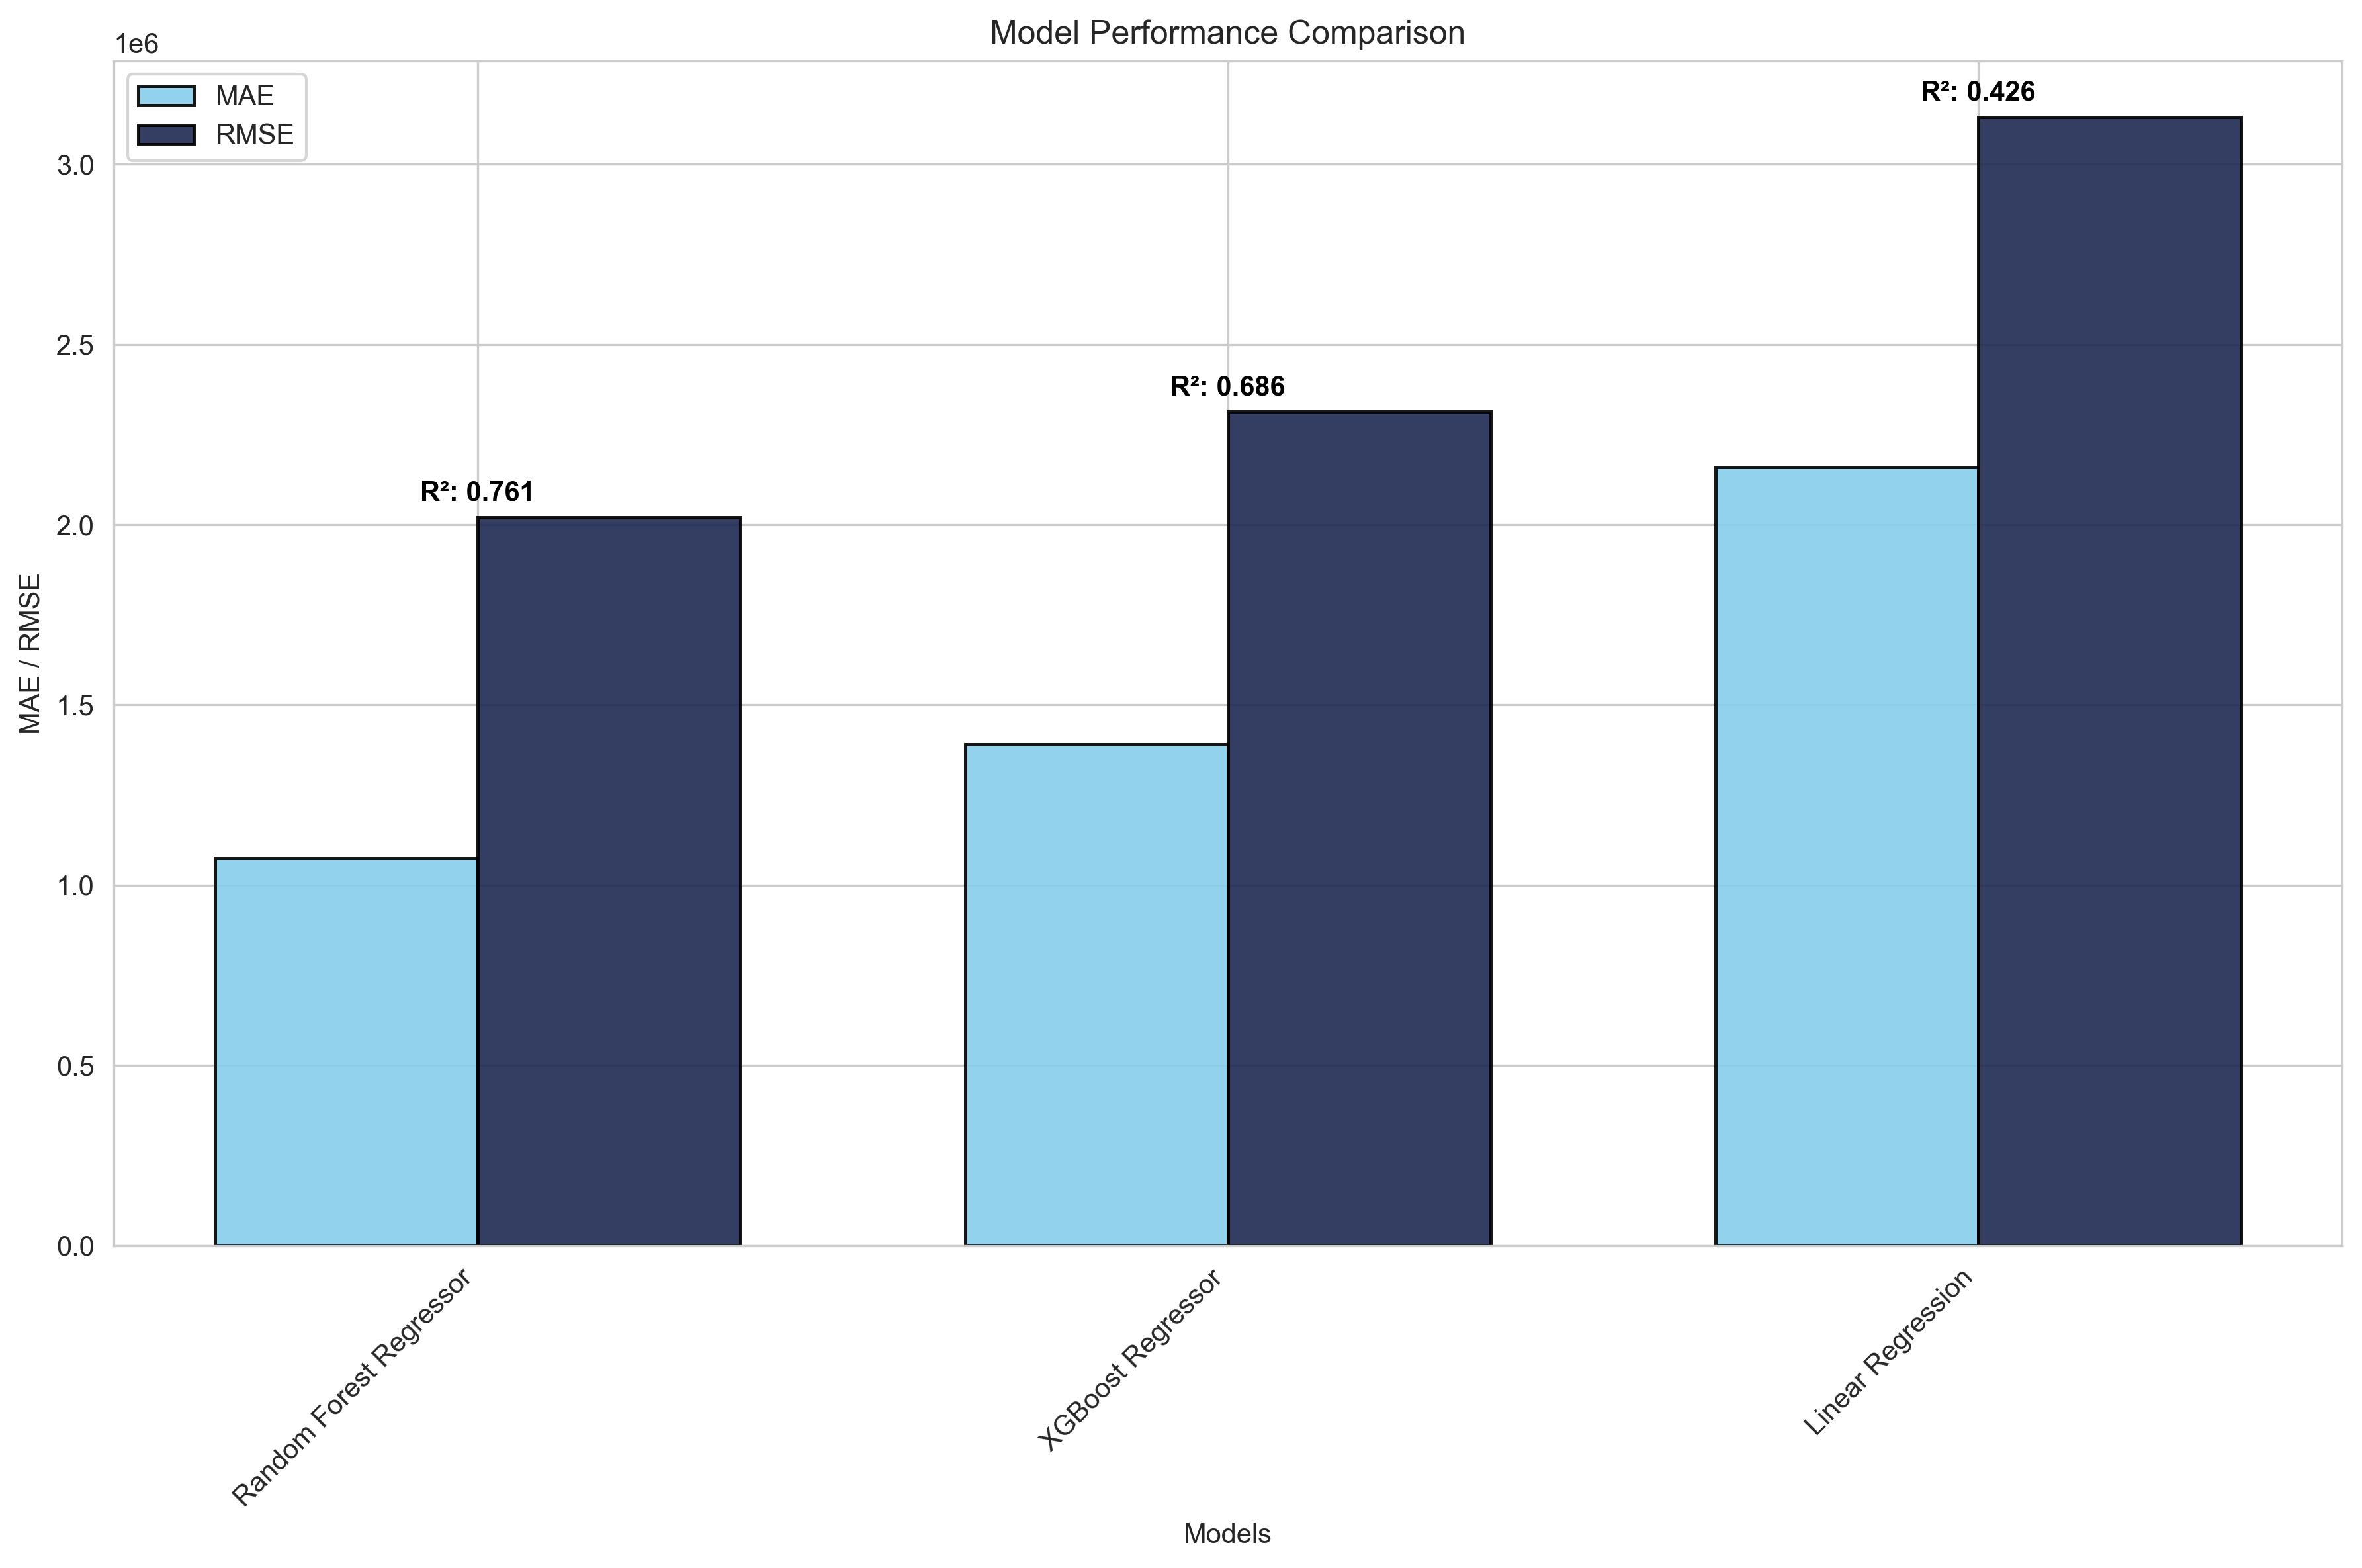

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=50, random_state=42),
    "XGBoost Regressor": xgb.XGBRegressor(n_estimators=50, random_state=42)
}

# Train models and evaluate performance
results = {}

for model_name, model in models.items():
    model.fit(X_train_normal, y_train)
    y_pred = model.predict(X_test_normal)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE calculation
    r2 = r2_score(y_test, y_pred)

    results[model_name] = {'MAE': mae, 'RMSE': rmse, 'R²': r2}

# Convert results to DataFrame
results_df = pd.DataFrame(results).T  # Transpose for readability
print(results_df)

# Sort results for better visualization
sorted_results = sorted(results.items(), key=lambda x: x[1]['MAE'])

# Extract metrics for plotting
model_names = [x[0] for x in sorted_results]
mae_values = [x[1]['MAE'] for x in sorted_results]
rmse_values = [x[1]['RMSE'] for x in sorted_results]
r2_values = [x[1]['R²'] for x in sorted_results]

# Plot the metrics
x = np.arange(len(model_names))  # Label locations
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(12, 8))

# Plot MAE and RMSE bars
ax.bar(x - width/2, mae_values, width, label='MAE', color='#87CEEB', edgecolor='black', linewidth=1.2, alpha=0.9)
ax.bar(x + width/2, rmse_values, width, label='RMSE', color='#1D2951', edgecolor='black', linewidth=1.2, alpha=0.9)

# Add R² values as text on top of bars
for i, (mae, rmse, r2) in enumerate(zip(mae_values, rmse_values, r2_values)):
    ax.text(i, rmse + 0.01 * max(rmse_values), f'R²: {r2:.3f}', 
            ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

# Labels, title, and formatting
ax.set_xlabel('Models')
ax.set_ylabel('MAE / RMSE')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

As we can see, even after transforming data, the well-known machine learning models do not give impressive results. The Random Forest Regressor has so far the best predictibility with R² = 0.76. <br>
In the next part, we develop a neural network model which may improve the results.

### Build Neural Network with Training Data

In [51]:
# Ensure target variables are NumPy arrays
y_train = np.array(y_train).astype(np.float32).reshape(-1, 1)  # Explicit conversion
y_test = np.array(y_test).astype(np.float32).reshape(-1, 1)

# Ensure target variables are NumPy arrays
y_train = np.array(y_train).astype(np.float32).reshape(-1, 1)  # Explicit conversion
y_test = np.array(y_test).astype(np.float32).reshape(-1, 1)

# Set random seed
tf.random.set_seed(66)

# Define the model
nba_model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1)  # Output layer for regression
])

# Compile the model
nba_model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=["mae"])

# Train the model
fit_data = nba_model.fit(X_train_normal, y_train, epochs=100, verbose=0)

# Make predictions AFTER training
y_pred = nba_model.predict(X_test_normal).flatten()

# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")




66/66 [==============================] - 1s 5ms/step
MAE: 1497817.75
RMSE: 1691.5844643410508
R²: 0.5202745199203491


Evaulate NBA model

In [52]:
nba_model_loss, nba_model_mae = nba_model.evaluate(X_test_normal, y_test)

66/66 [==============================] - 1s 4ms/step - loss: 1497817.7500 - mae: 1497817.7500


#### Calculate prediction measures (MAE, RMSE, R²)

Plot to see How Increasing Epochs Decreases Loss

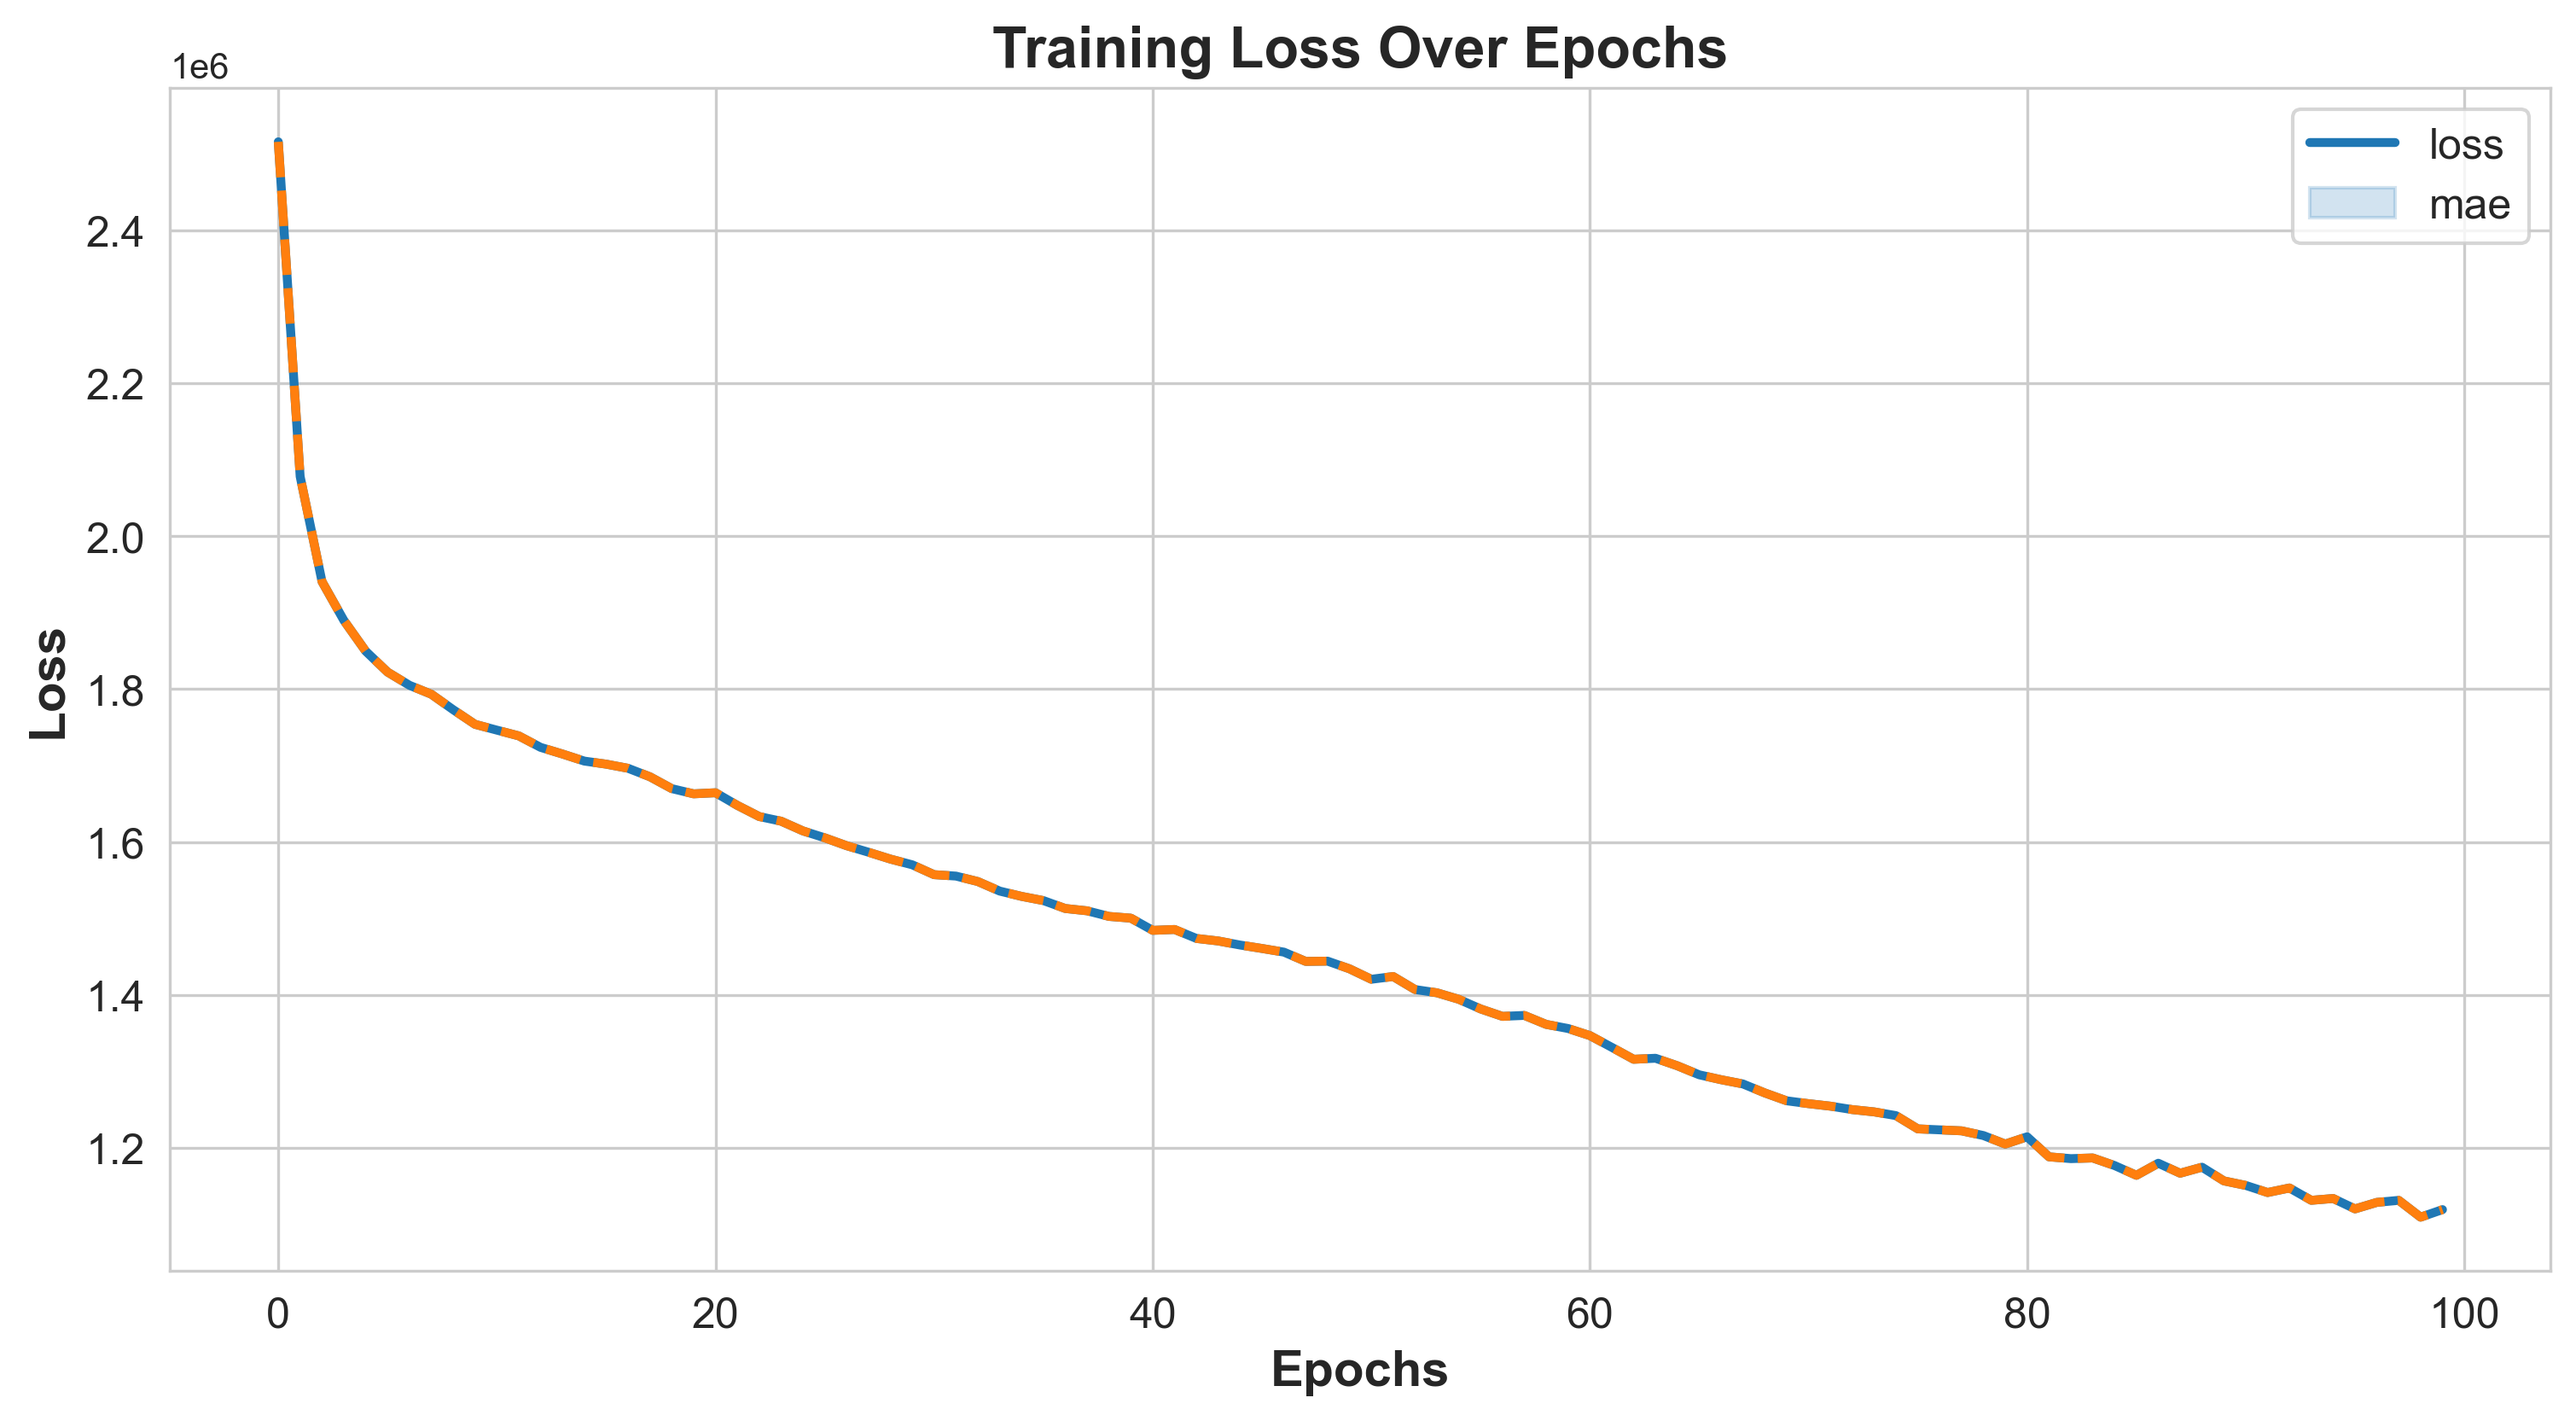

In [53]:
# Set figure size and style
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Plot training loss
sns.lineplot(data=fit_data.history, linewidth=2.5, palette="tab10")

# Customize labels and title
plt.xlabel("Epochs", fontsize=14, fontweight='bold')
plt.ylabel("Loss", fontsize=14, fontweight='bold')
plt.title("Training Loss Over Epochs", fontsize=16, fontweight='bold')

# Improve tick visibility
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a legend for better understanding
plt.legend(labels=fit_data.history.keys(), fontsize=12, loc="upper right")

# Show the plot
plt.show()

In [54]:
# nba_salary_stats.to_csv("nba_salary_stats.csv", index=False)

### Feature Importance using Random Forest Regressor on the NBA dataset

C:\Users\ZhouZhou\AppData\Local\Temp\ipykernel_5716\3882492168.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


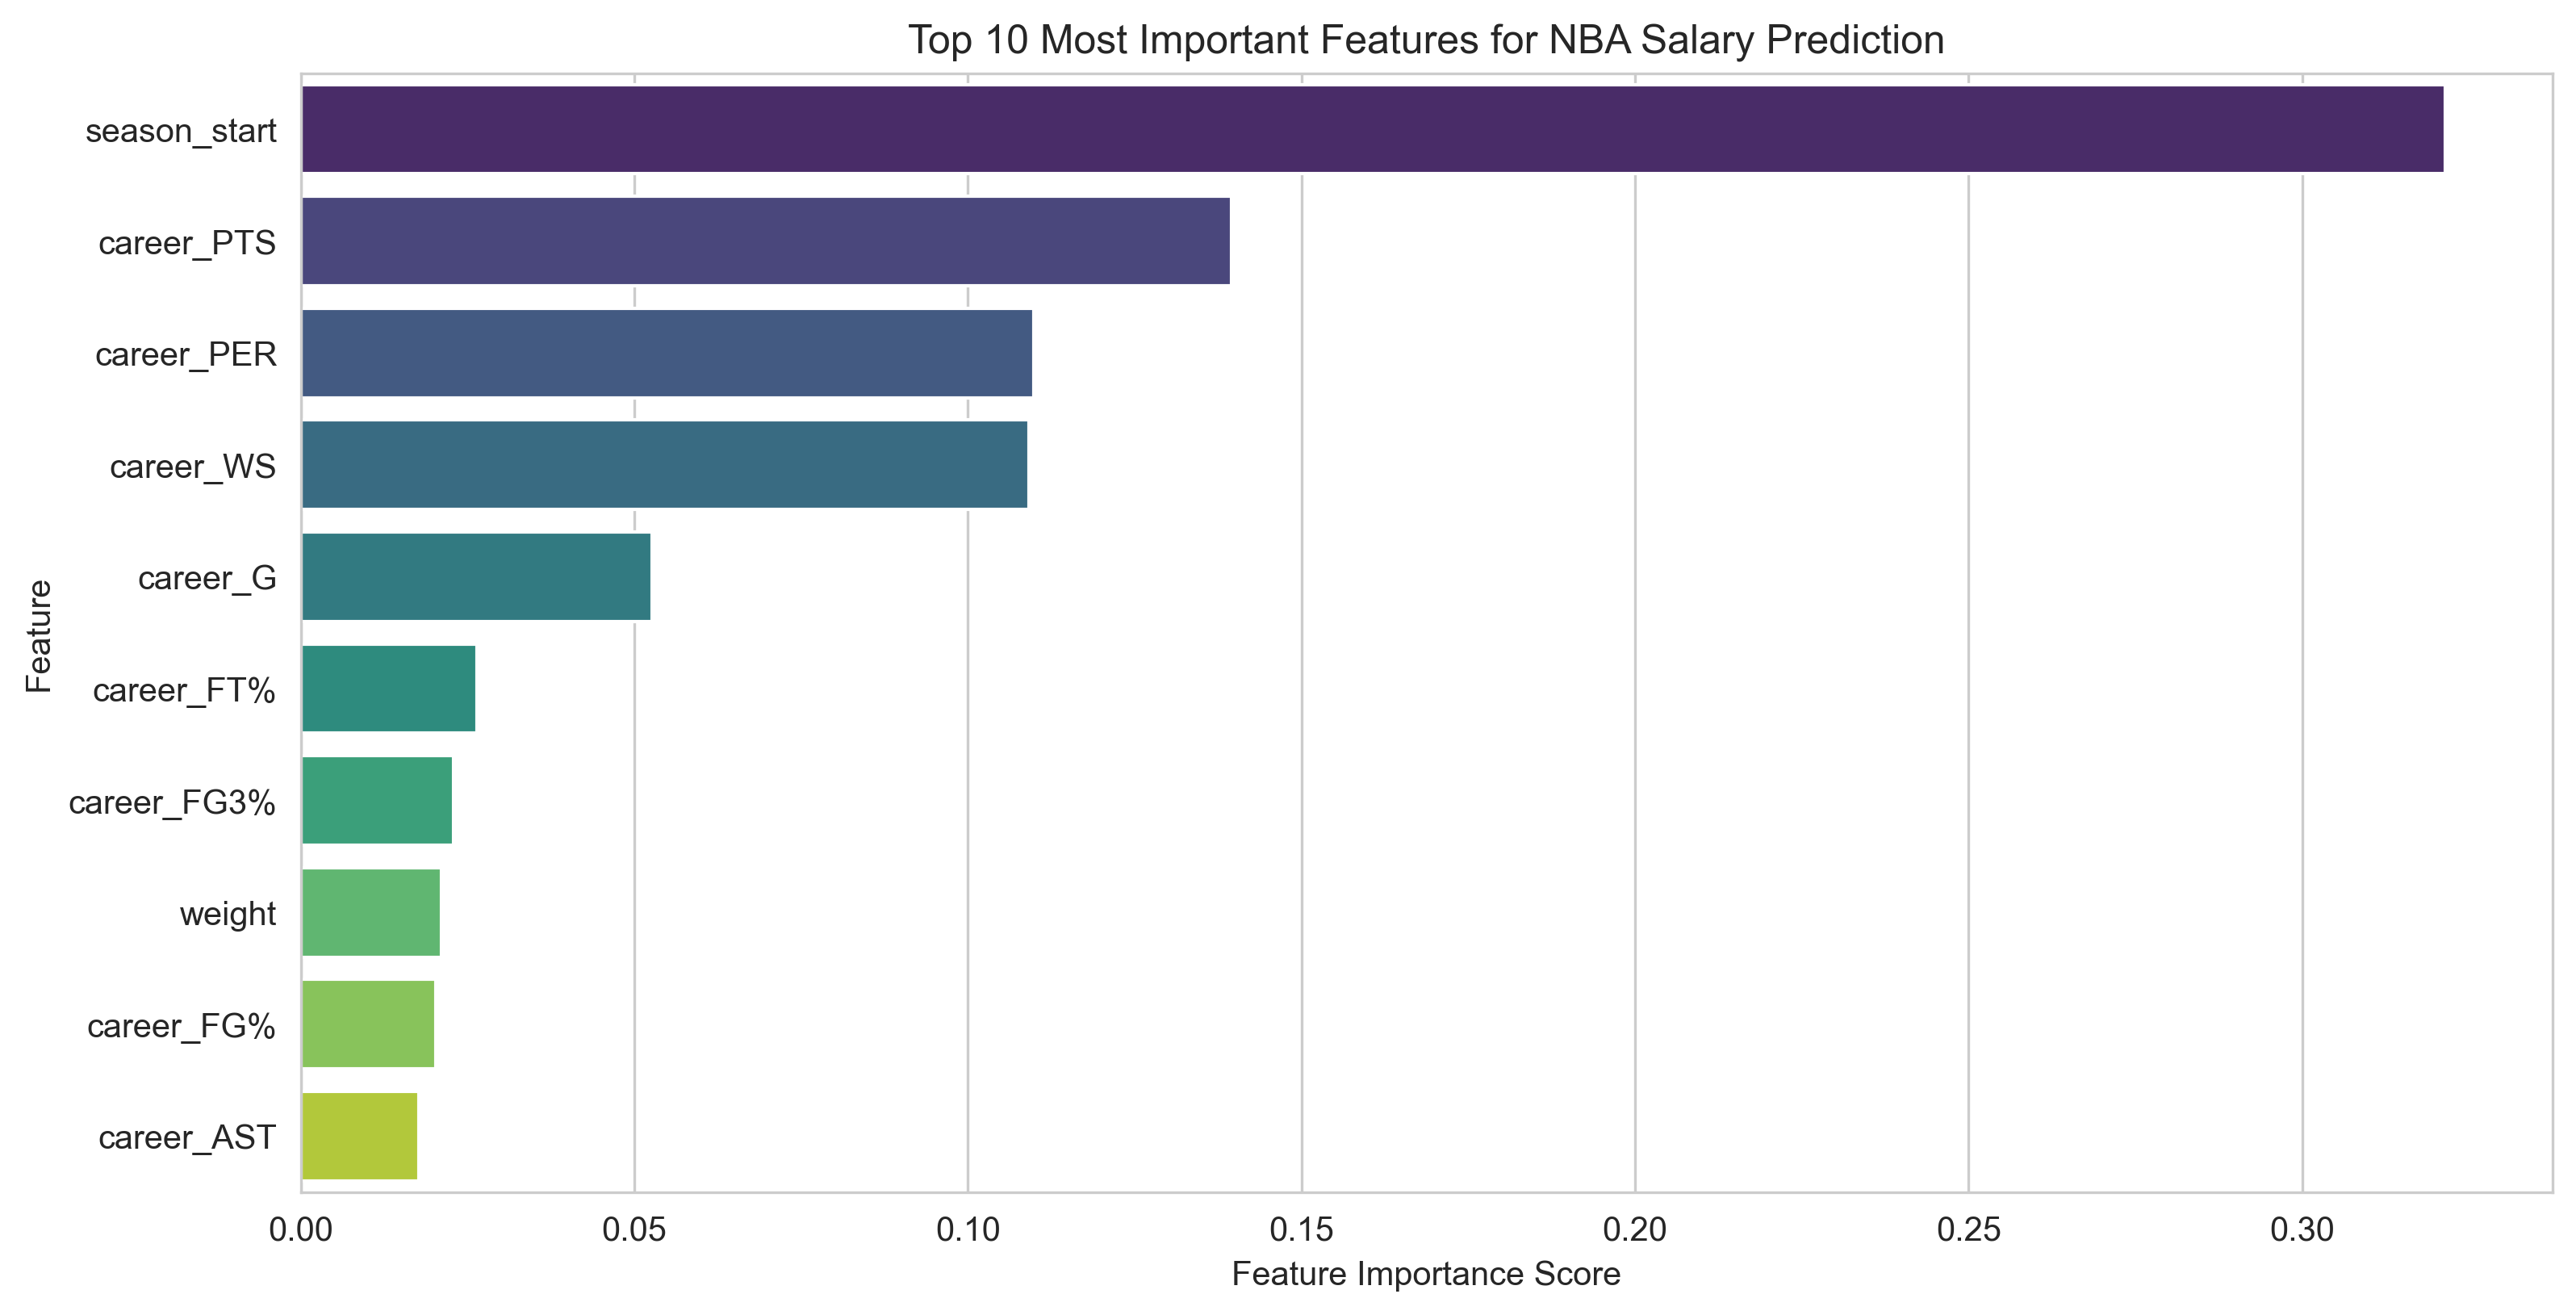

In [ ]:
# Load and prepare the data
X = nba_salary_stats.drop(columns=['salary'])  # Features
y = nba_salary_stats['salary']  # Target variable

# Convert categorical features using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Extract feature importance scores
feature_importances = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)  # Top 10 features

# Plot Feature Importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features for NBA Salary Prediction')
plt.show()